In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/'
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19030_sx1.fits'],
      dtype='<U67')

/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19020_x1d.fits
G230L
[513.3161]


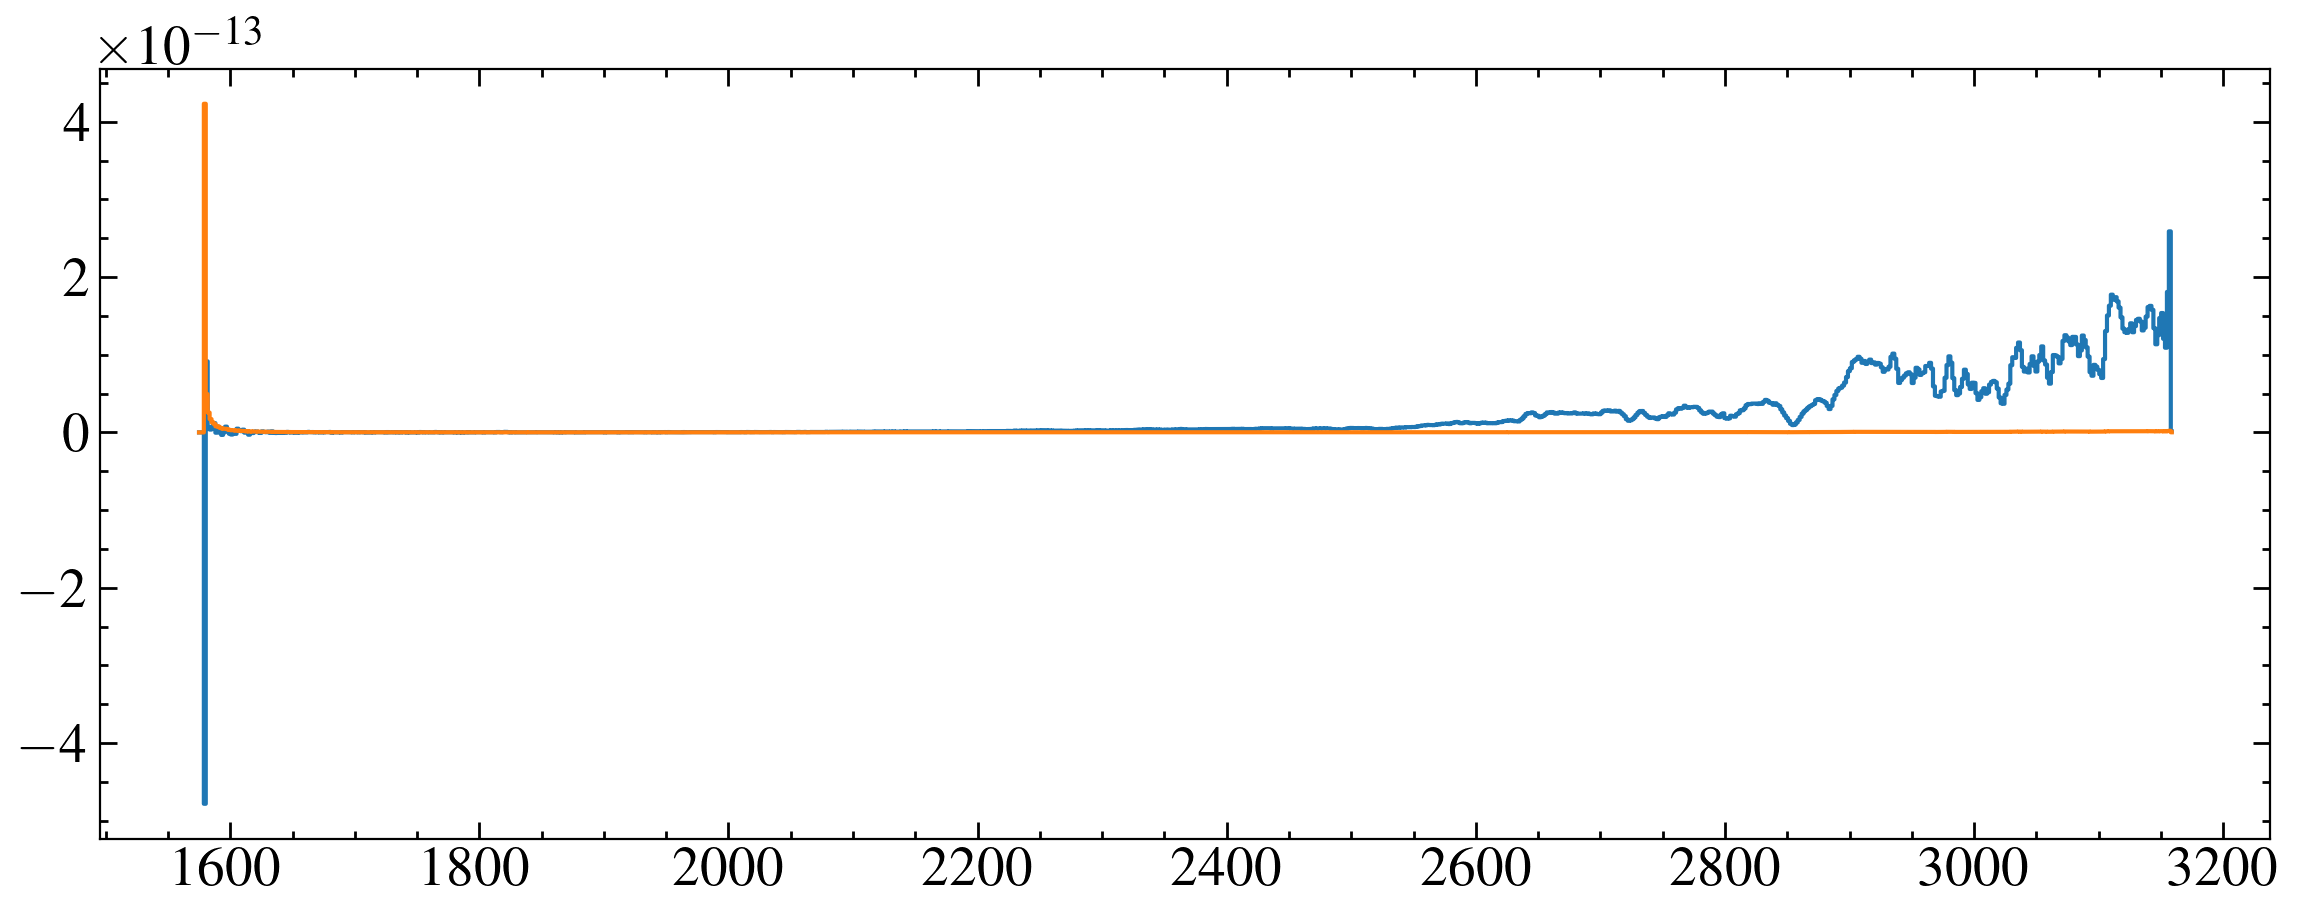

/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19010_x1d.fits
G140L
[512.59247]


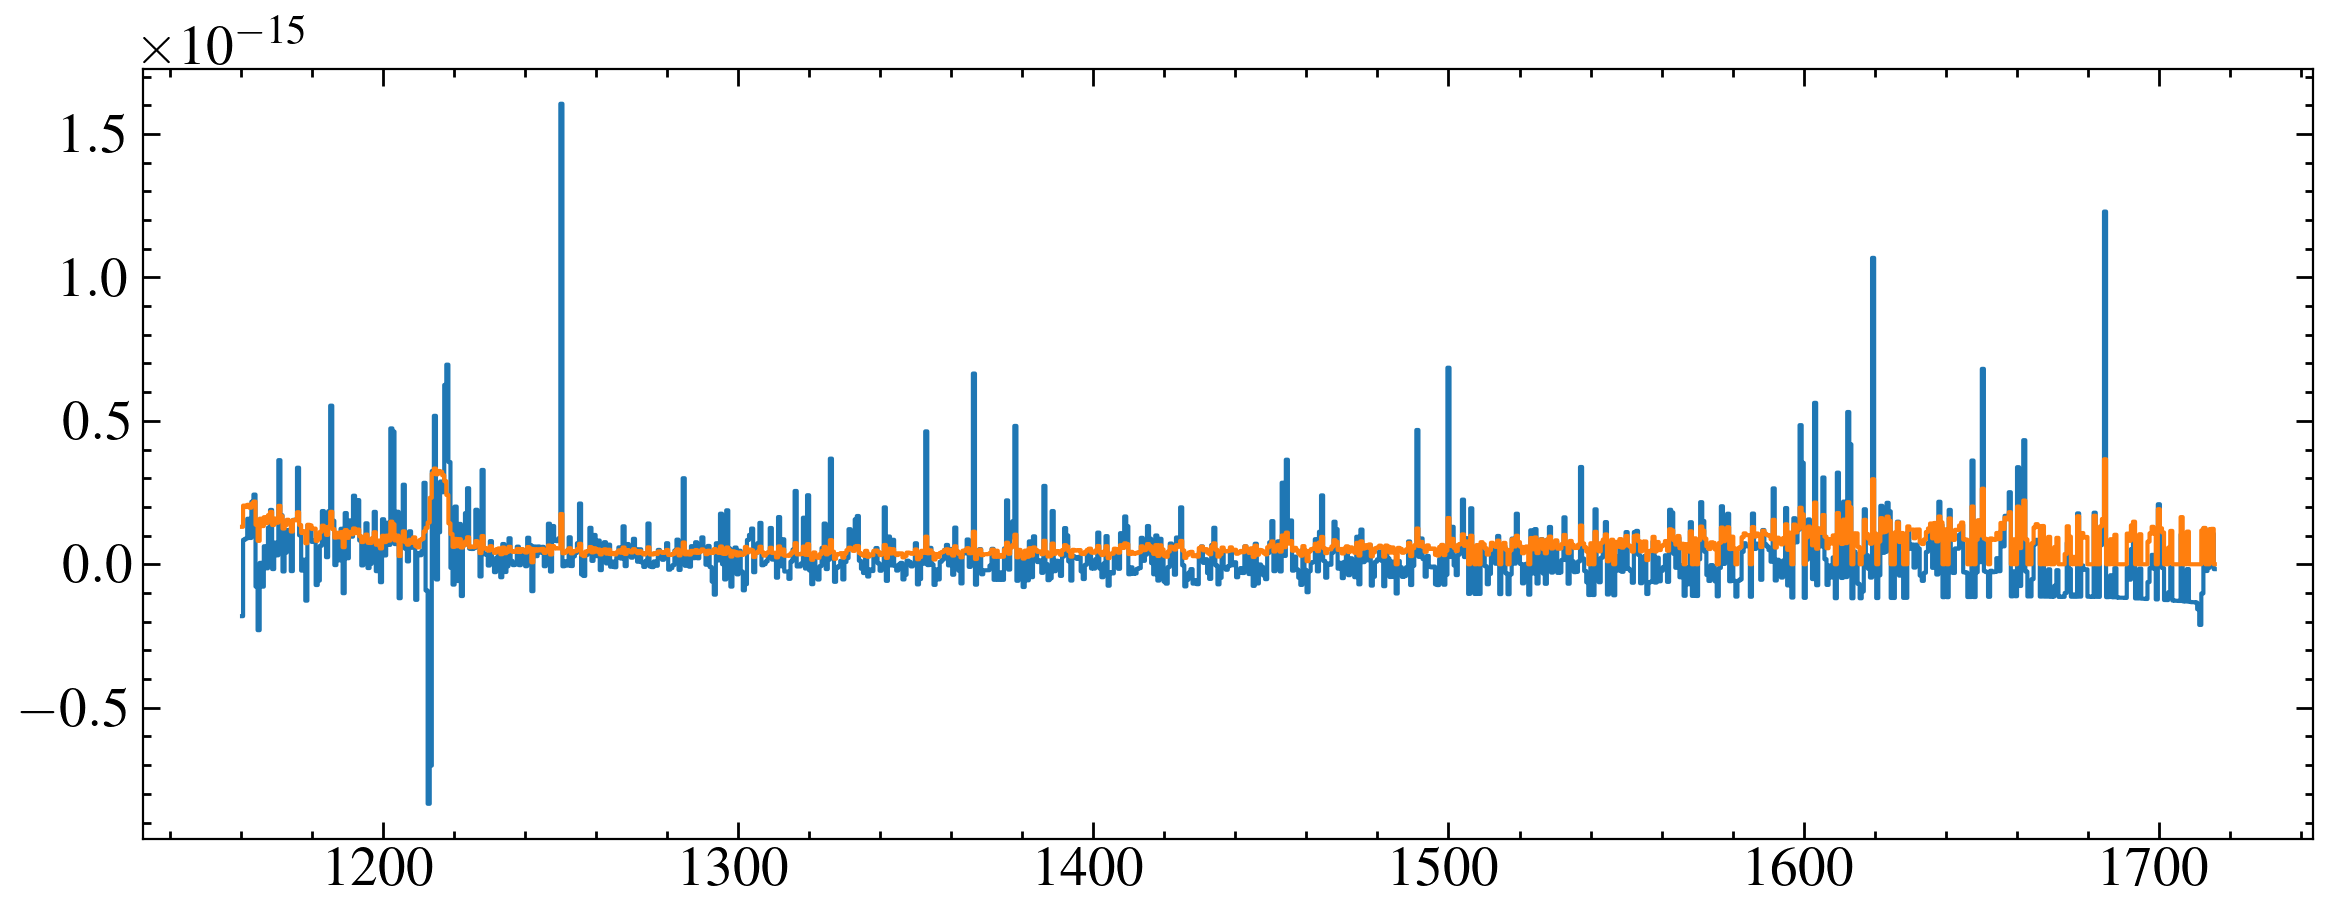

/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19030_sx1.fits
G430L
[894.47546]


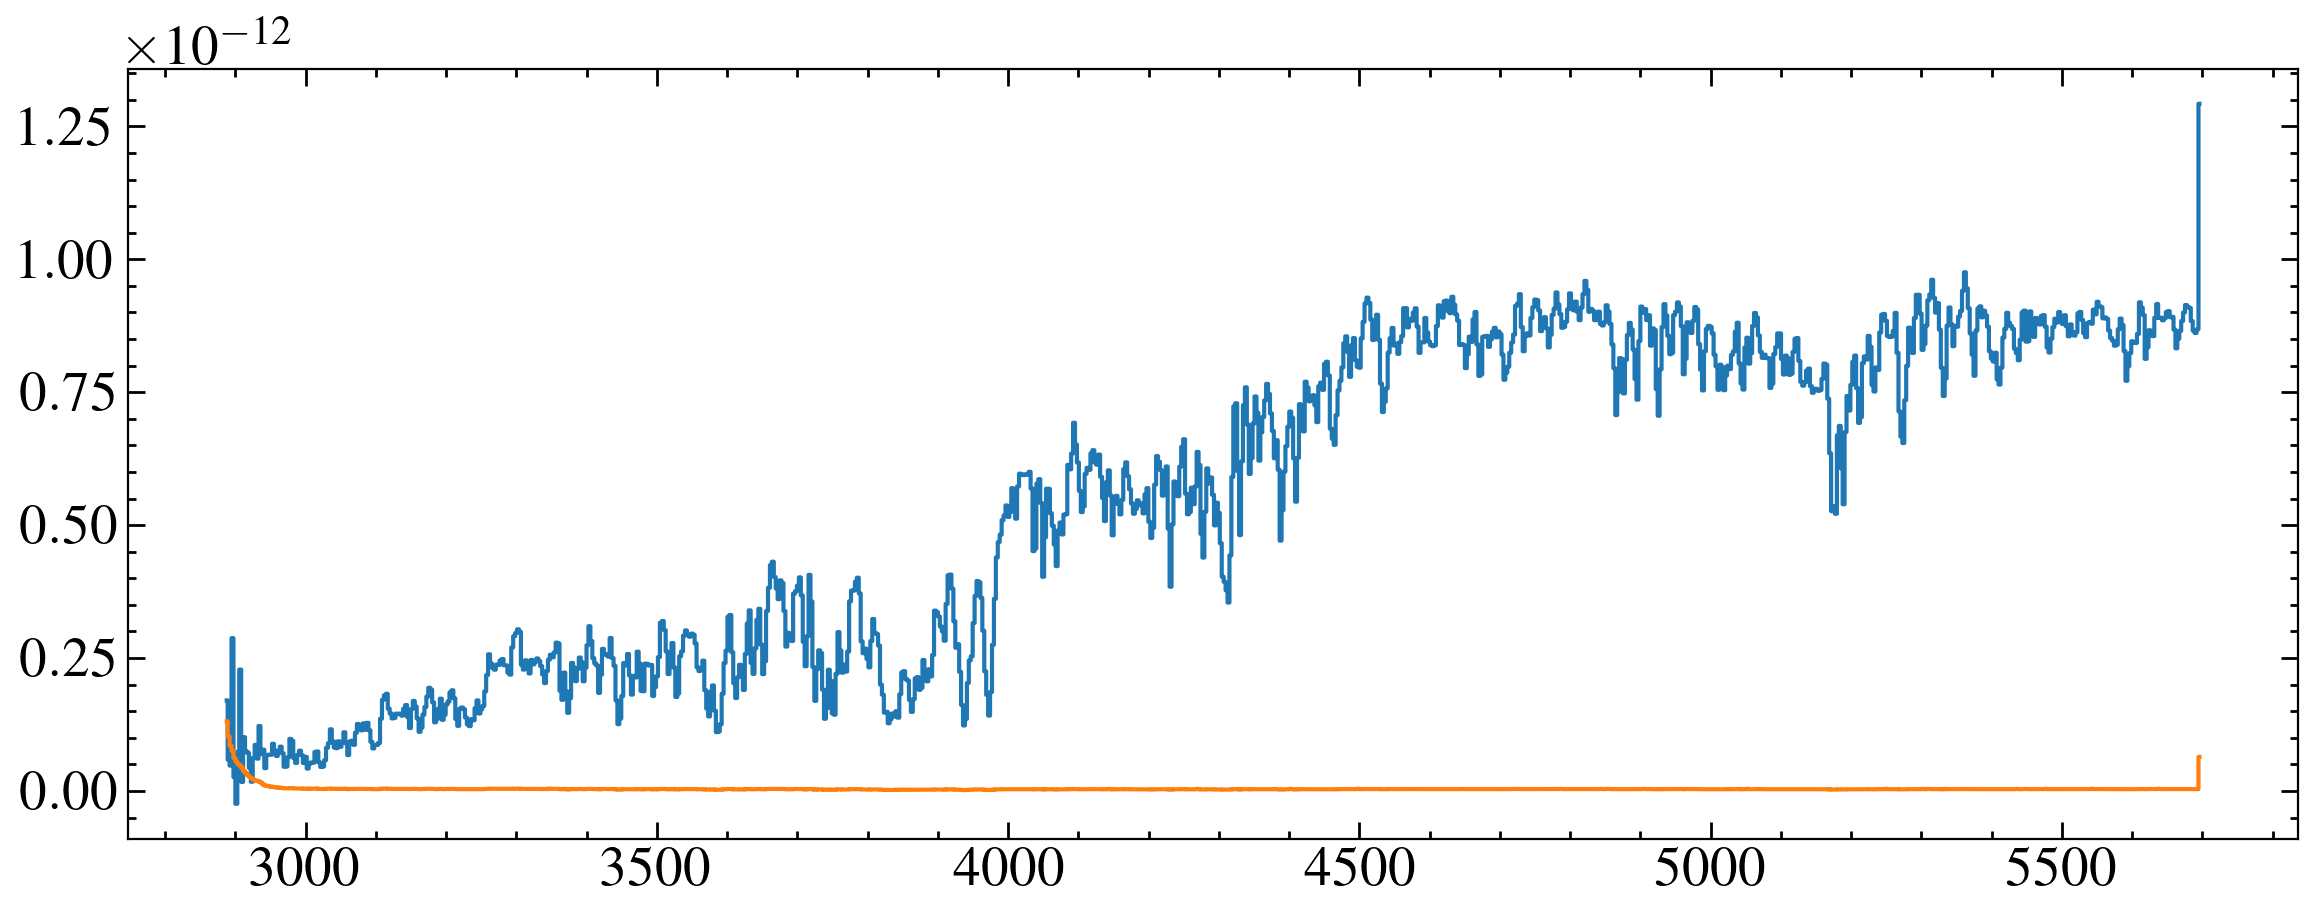

In [3]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    plt.show()

/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19020_x1d.fits
G230L
[513.3161]


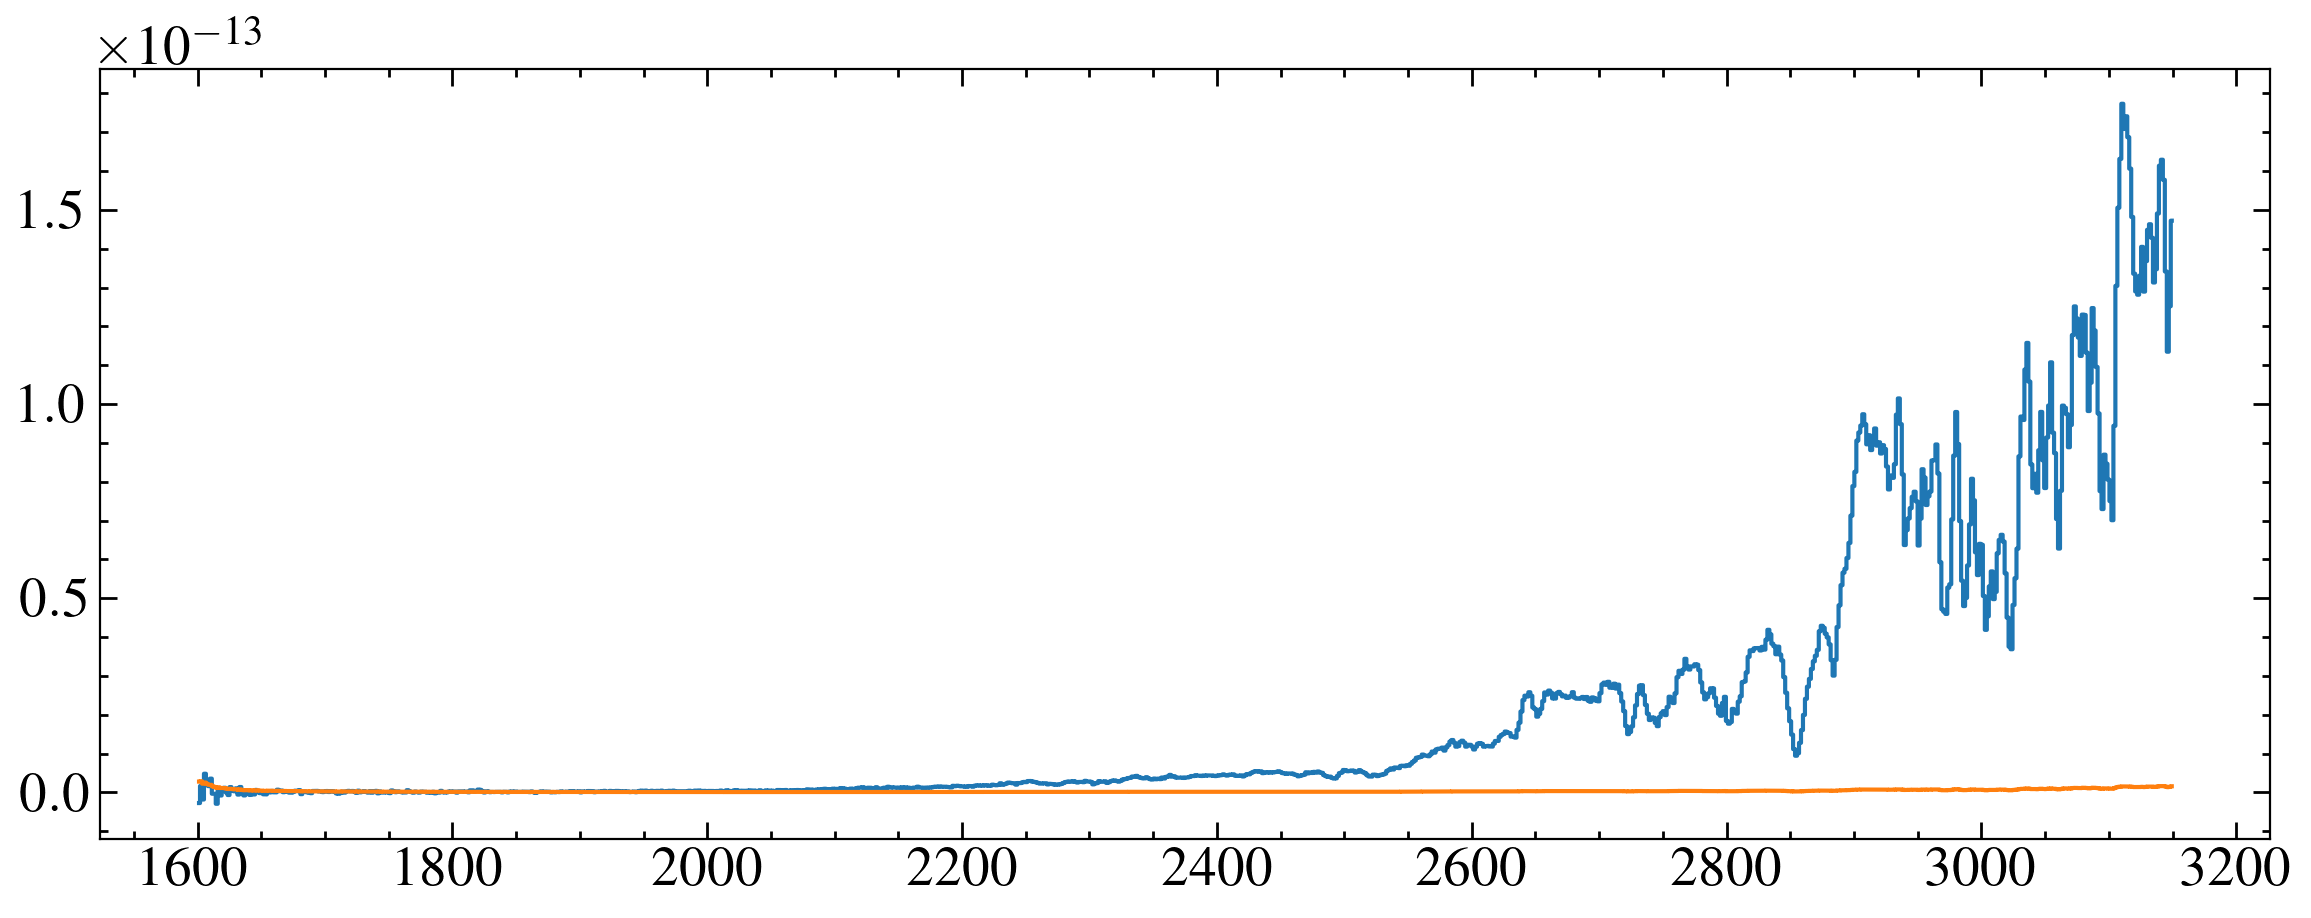

/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19010_x1d.fits
G140L
[512.59247]


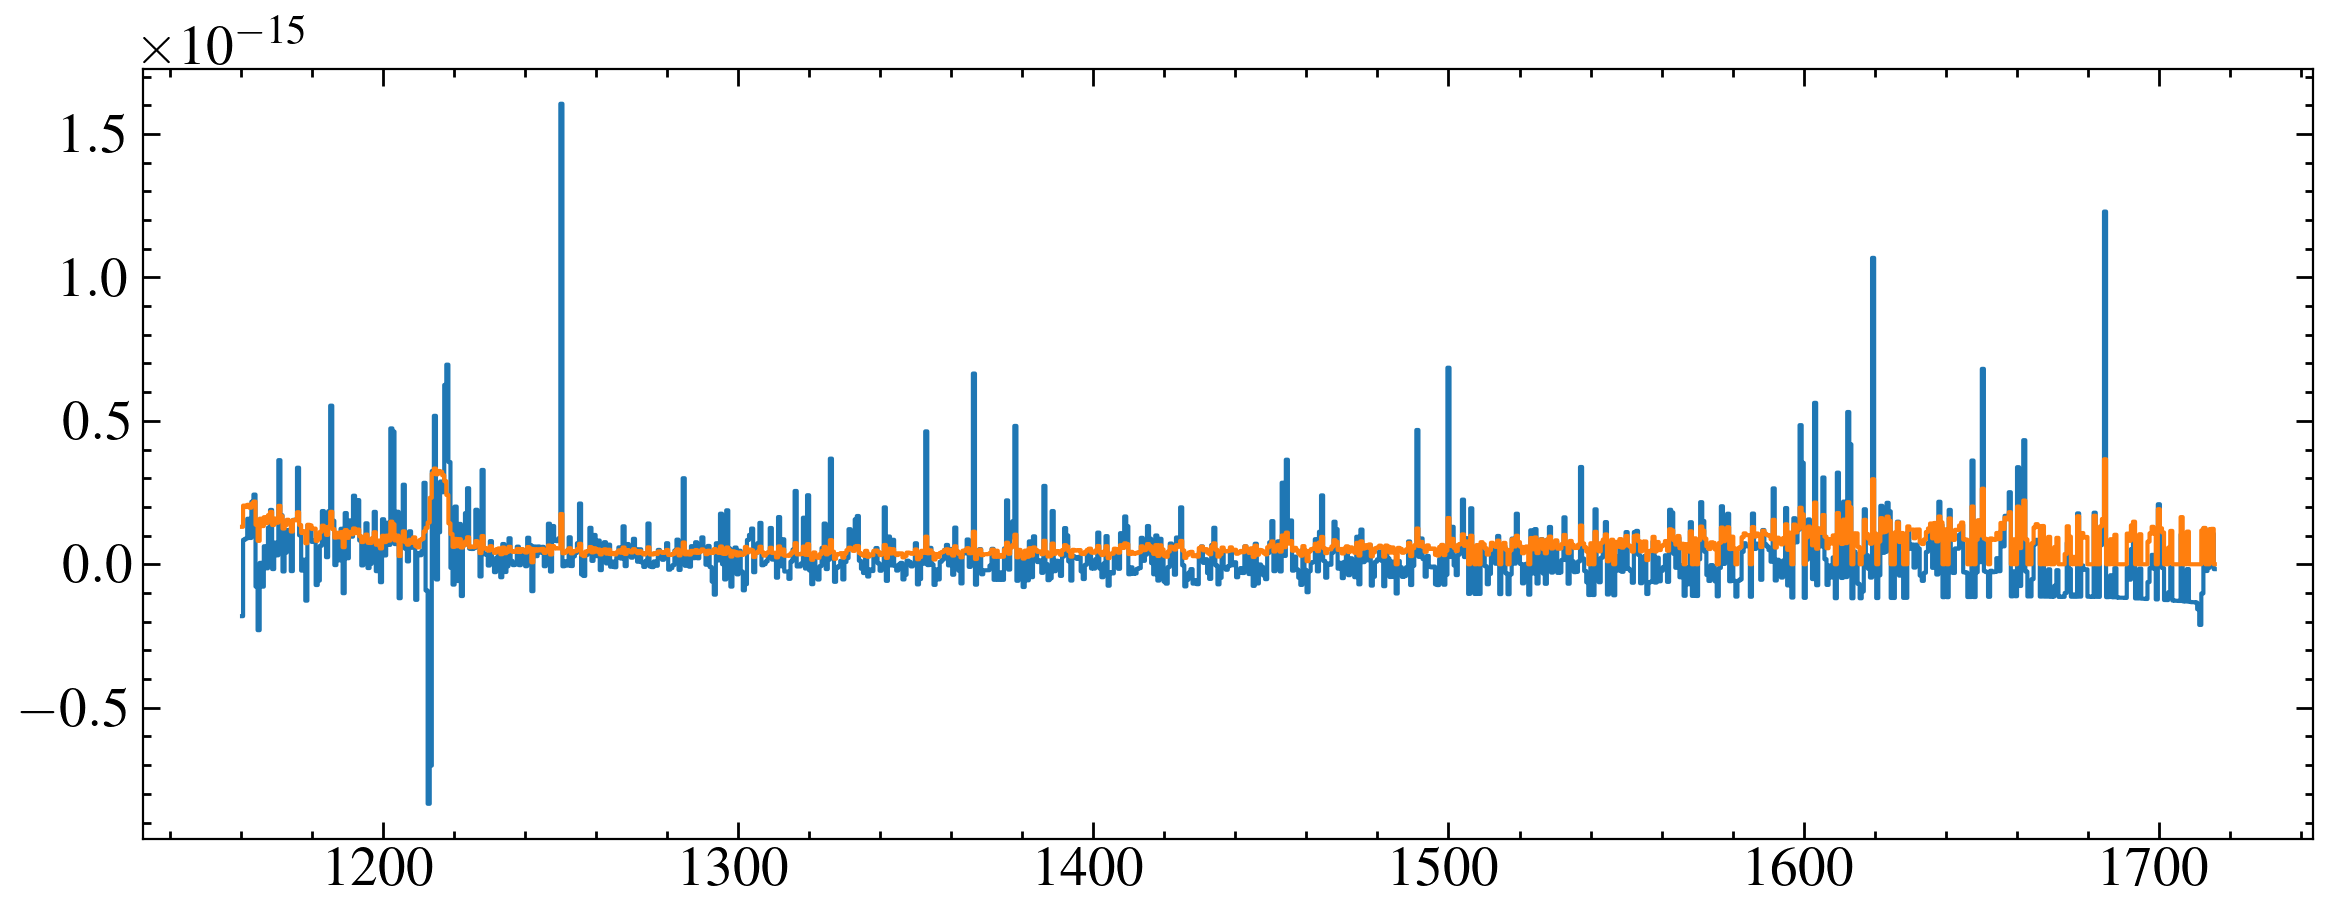

/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19030_sx1.fits
G430L
[894.47546]


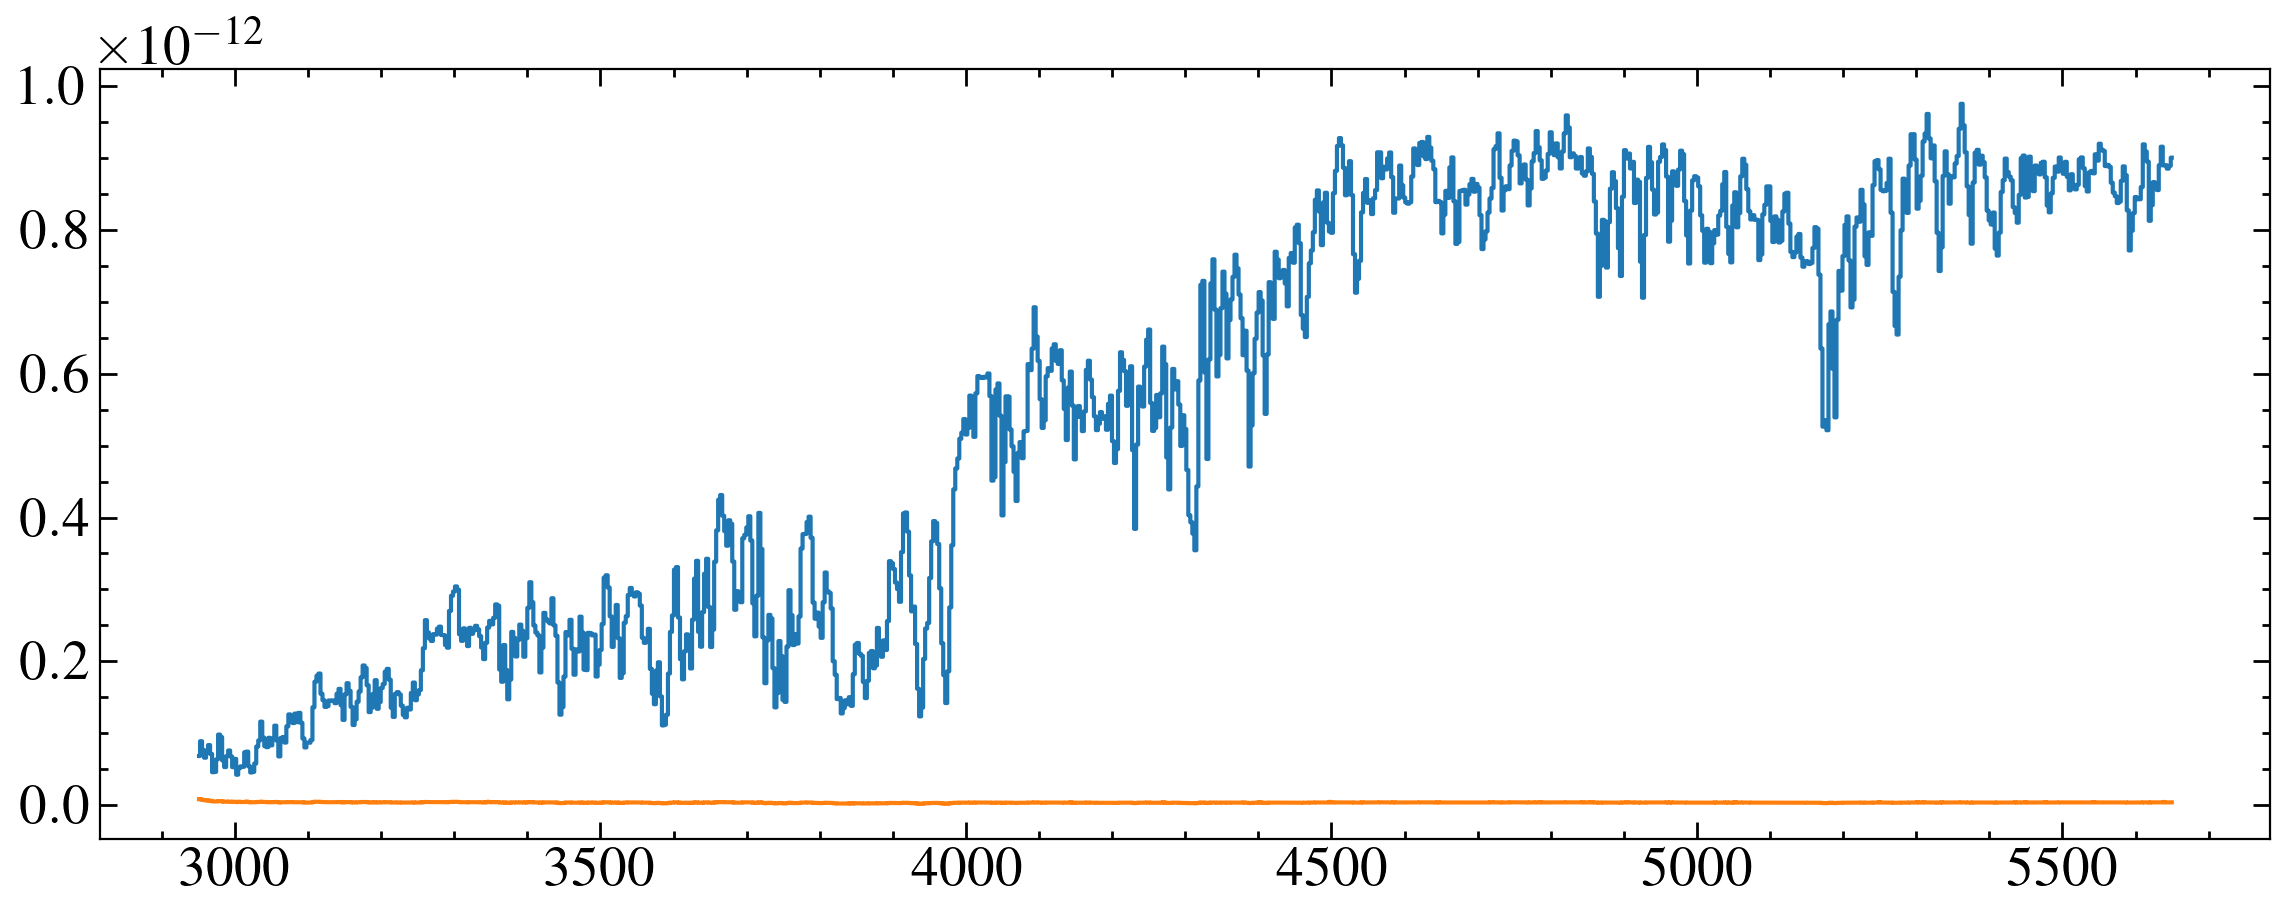

In [4]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140L', 'Gl40M']:
        mask = w > 1160
    if grating == 'G230L':
        mask = (w > 1600) & (w <3150)
    if grating == 'G430L':
        mask = (w > 2950) & (w < 5650)
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    # plt.yscale('log')
    plt.show()

/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19020_x1d.fits
G230L
[513.3161]
/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19010_x1d.fits
G140L
[512.59247]
/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19030_sx1.fits
G430L
[894.47546]


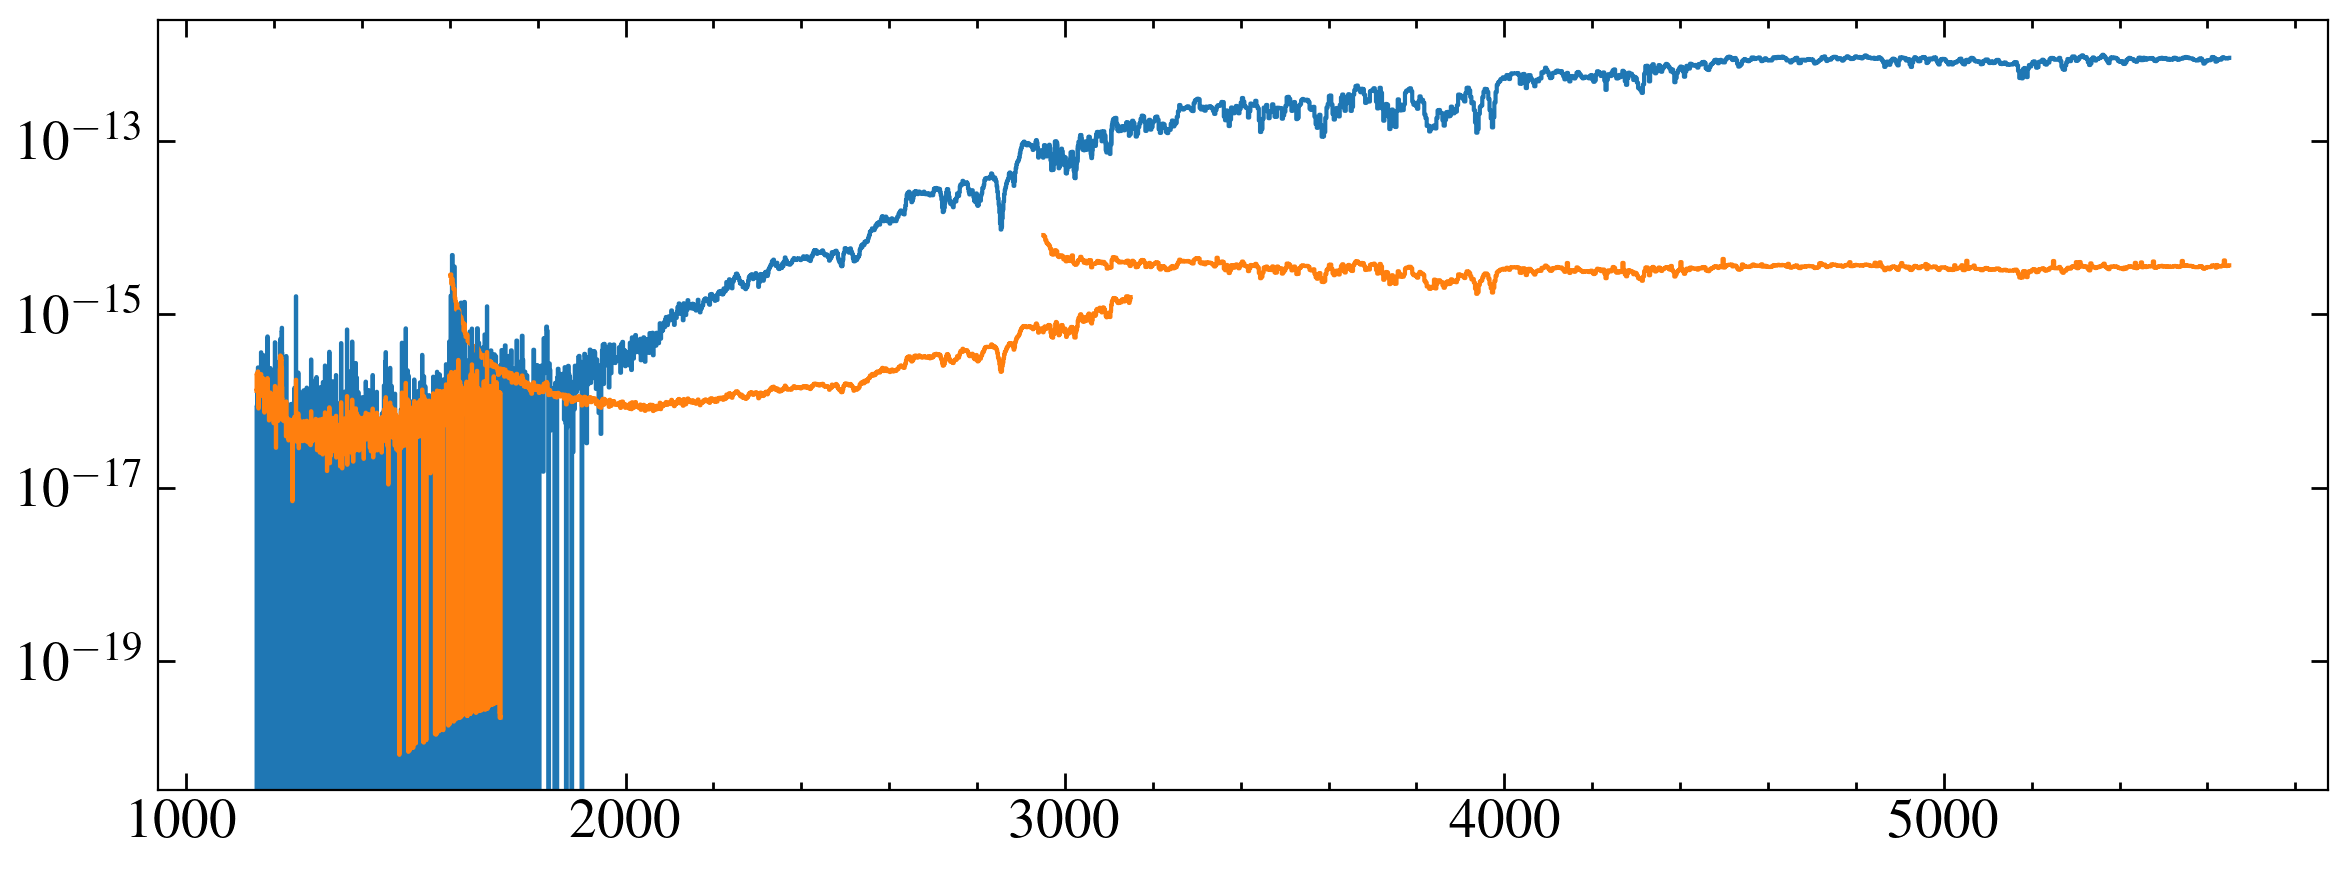

In [5]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140L', 'Gl40M']:
        mask = w > 1160
    if grating == 'G230L':
        mask = (w > 1600) & (w <3150)
    if grating == 'G430L':
        mask = (w > 2950) & (w < 5650)
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
plt.yscale('log')
    # plt.show()

Re-extracting the G140M spectrum.

In [6]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

In [7]:
#check background doesn't hit possible second trace
print(fits.getdata(x1ds[0], 1)['BK2OFFST'])

[300.]


In [8]:
import stistools
os.environ['oref'] = path

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [9]:
for root in  ['oeoo19010']:
    flt = '{}/{}_flt.fits'.format(path, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/toi-402/{}_new_x1d.fits'.format(rootname)
    a2center = get_a2center(373,376, tracegrid)
    print(a2center)
    # a2center = 375
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/toi-402/{}_new.trl'.format(rootname), a2center=a2center, maxsrch=5, bk1offst=-30, bk2offst=30)

378


377.28726


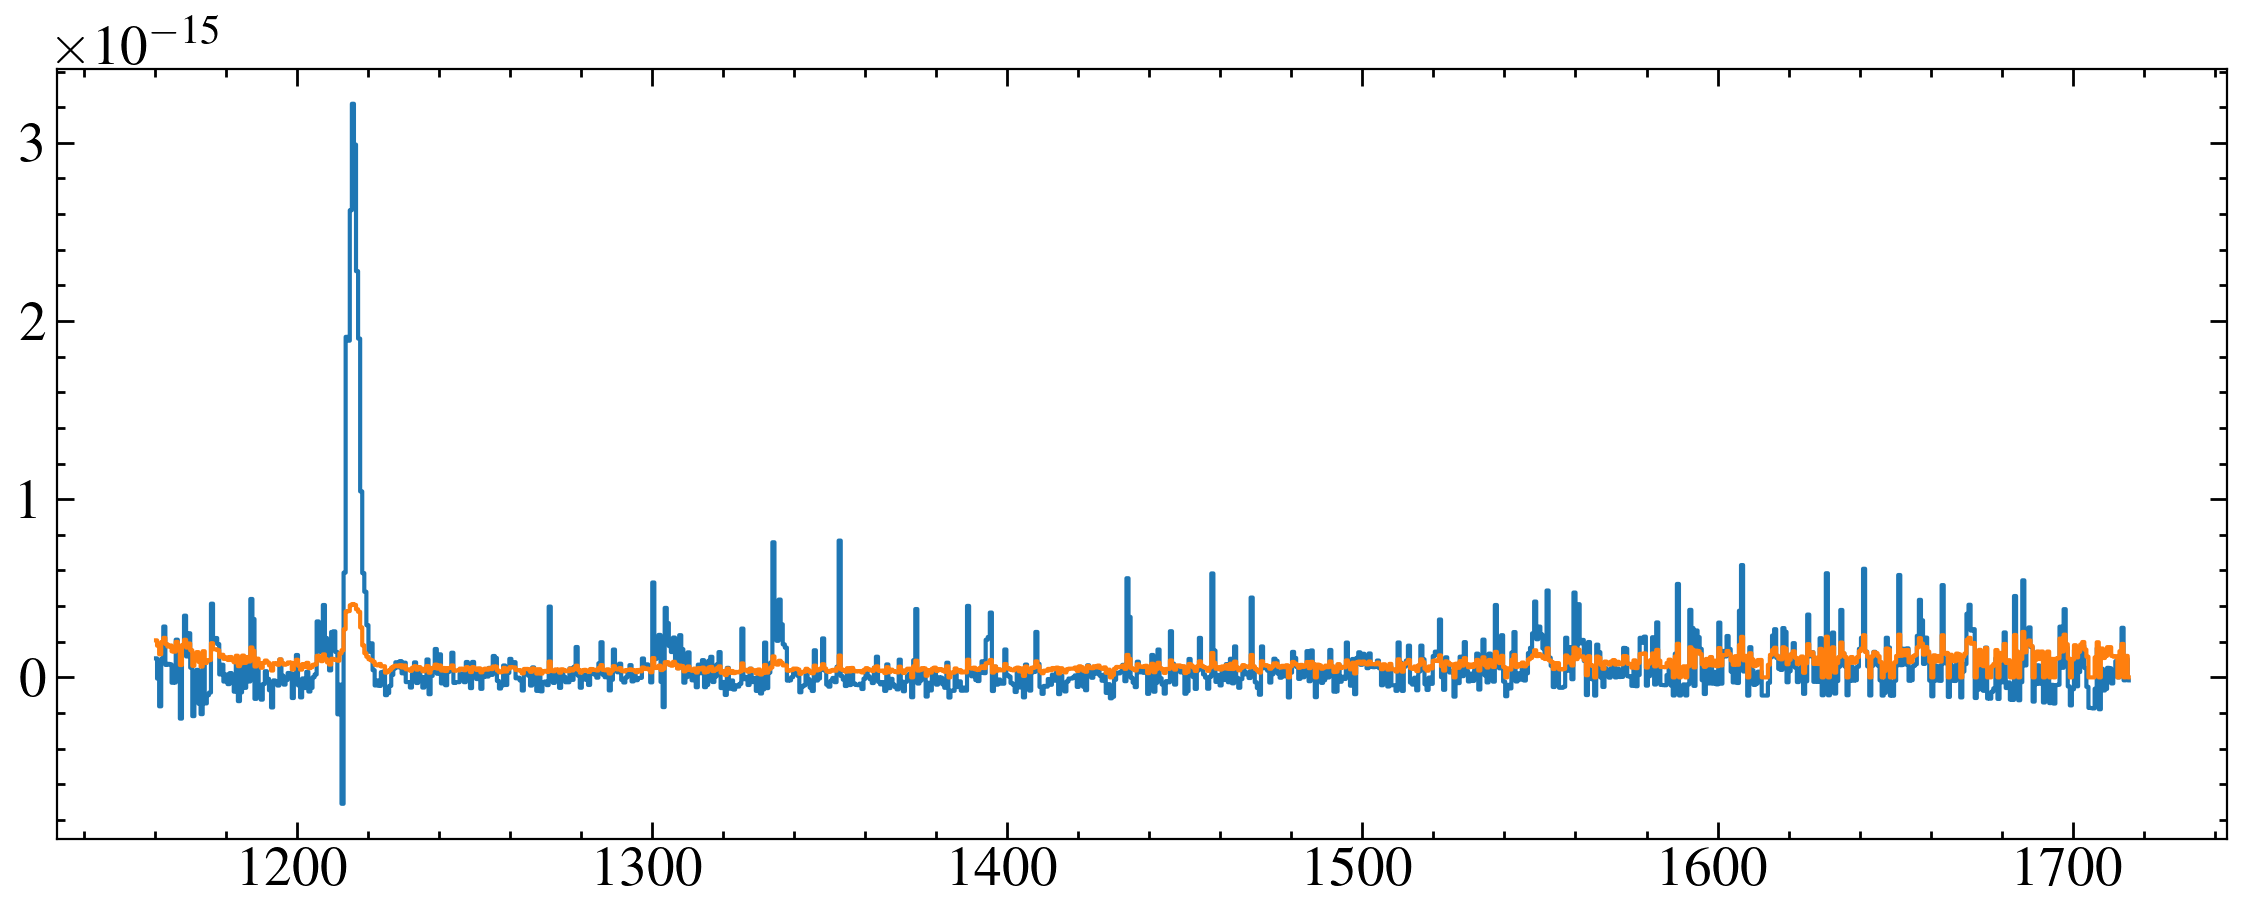

In [10]:
data = fits.getdata('reextractions/toi-402/oeoo19010_new_x1d.fits', 1)[0]
print(data['a2center'])
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = w > 1160
w, f, e = w[mask], f[mask], e[mask]
plt.step(w, f, where='mid', c='C0')
plt.step(w, e, where='mid', c='C1') 

In [51]:
# #and the interloper?
# for root in  ['oeoo19010']:
#     flt = '{}/{}_flt.fits'.format(path, root)
#     SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
#     grating = fits.getheader(flt,0)['OPT_ELEM']
#     cenwave = fits.getheader(flt,0)['CENWAVE']
#     tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
#     rootname = fits.getheader(flt)['ROOTNAME']
#     rootname = 'random_{}'.format(rootname) 
#     outname = 'reextractions/toi-402/{}_new_x1d.fits'.format(rootname)
#     a2center = get_a2center(243.9,492.7, tracegrid)
#     print(a2center)
#     a2center = 650
#     stistools.x1d.x1d(flt, output = outname, trailer='reextractions/toi-402/{}_new.trl'.format(rootname), a2center=a2center, maxsrch=5, bk1offst=-30, bk2offst=30)

495


646.65796


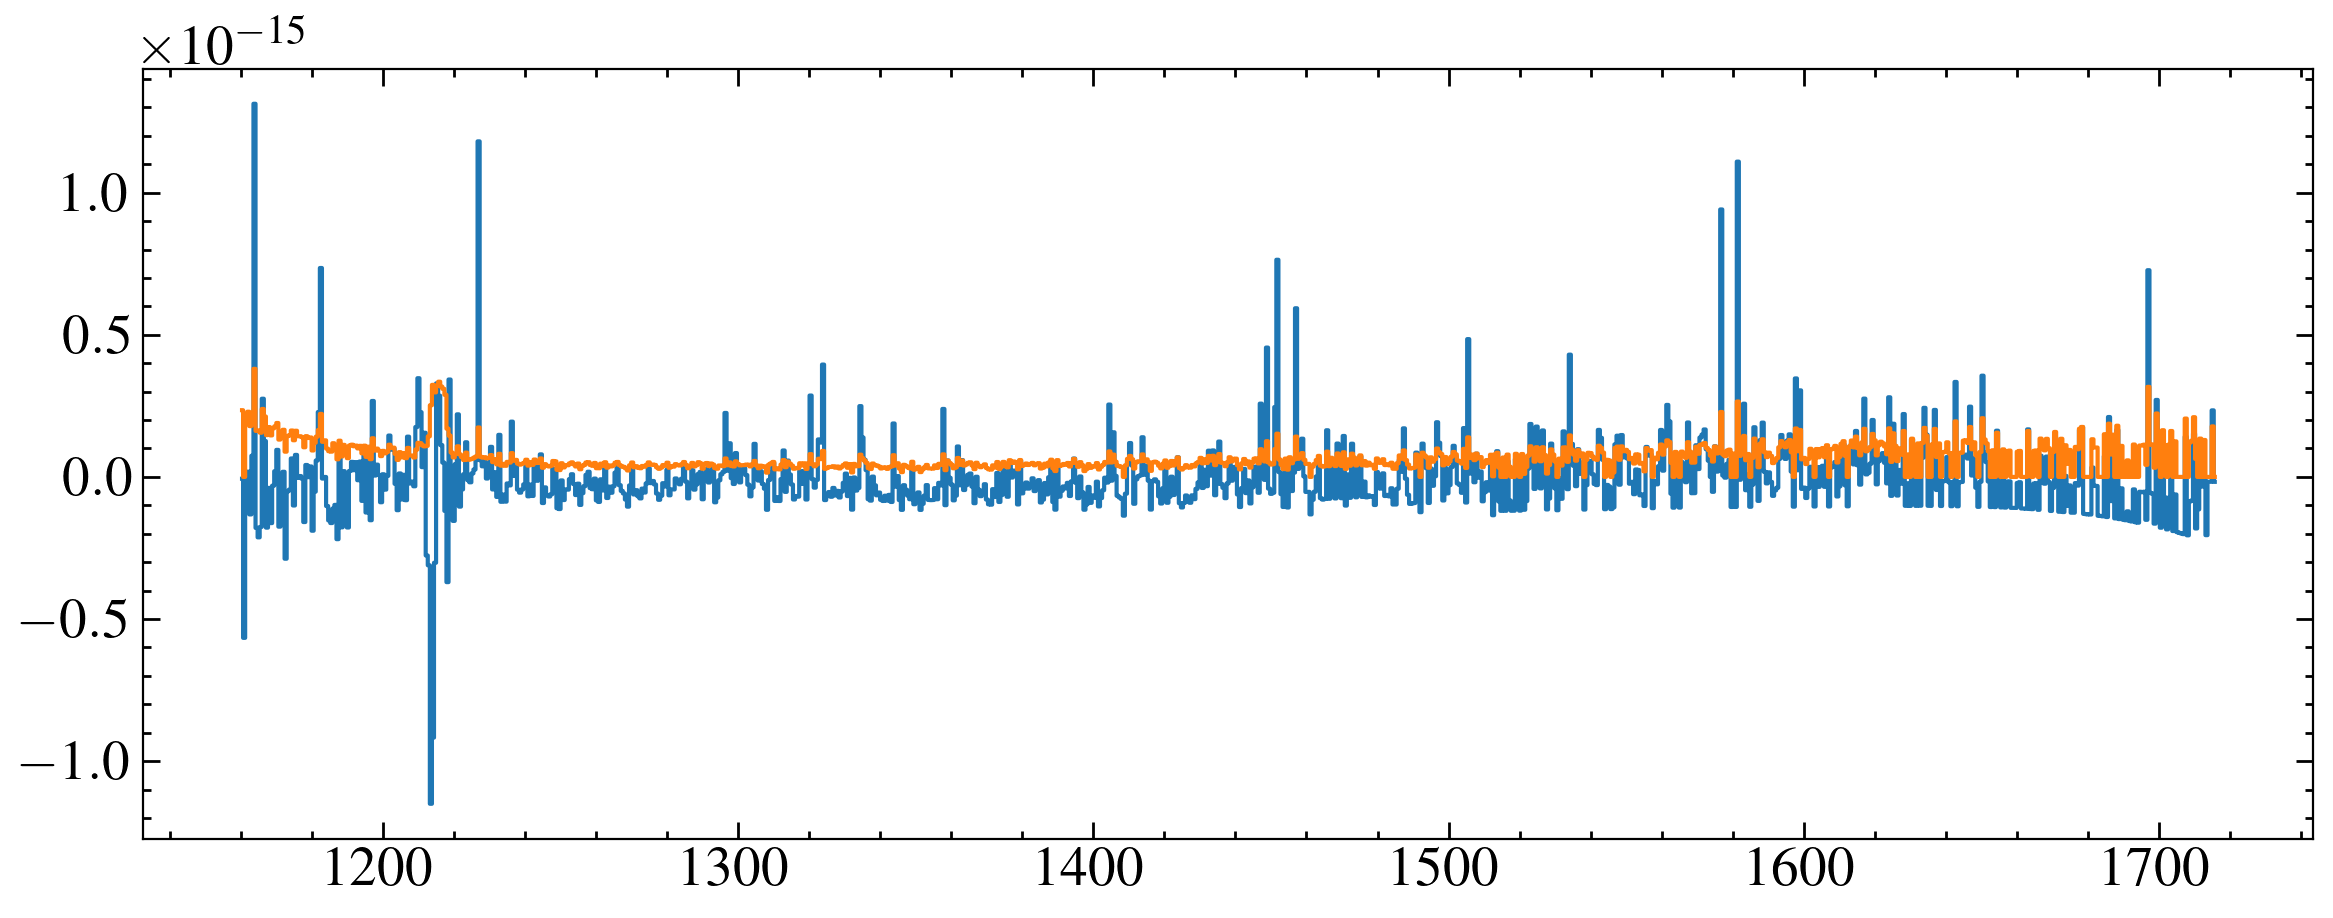

In [53]:
# data = fits.getdata('reextractions/toi-402/random_oeoo19010_new_x1d.fits', 1)[0]
# print(data['a2center'])
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
# mask = w > 1160
# w, f, e = w[mask], f[mask], e[mask]
# plt.step(w, f, where='mid', c='C0')
# plt.step(w, e, where='mid', c='C1') 

(1160.0, 1710.0)

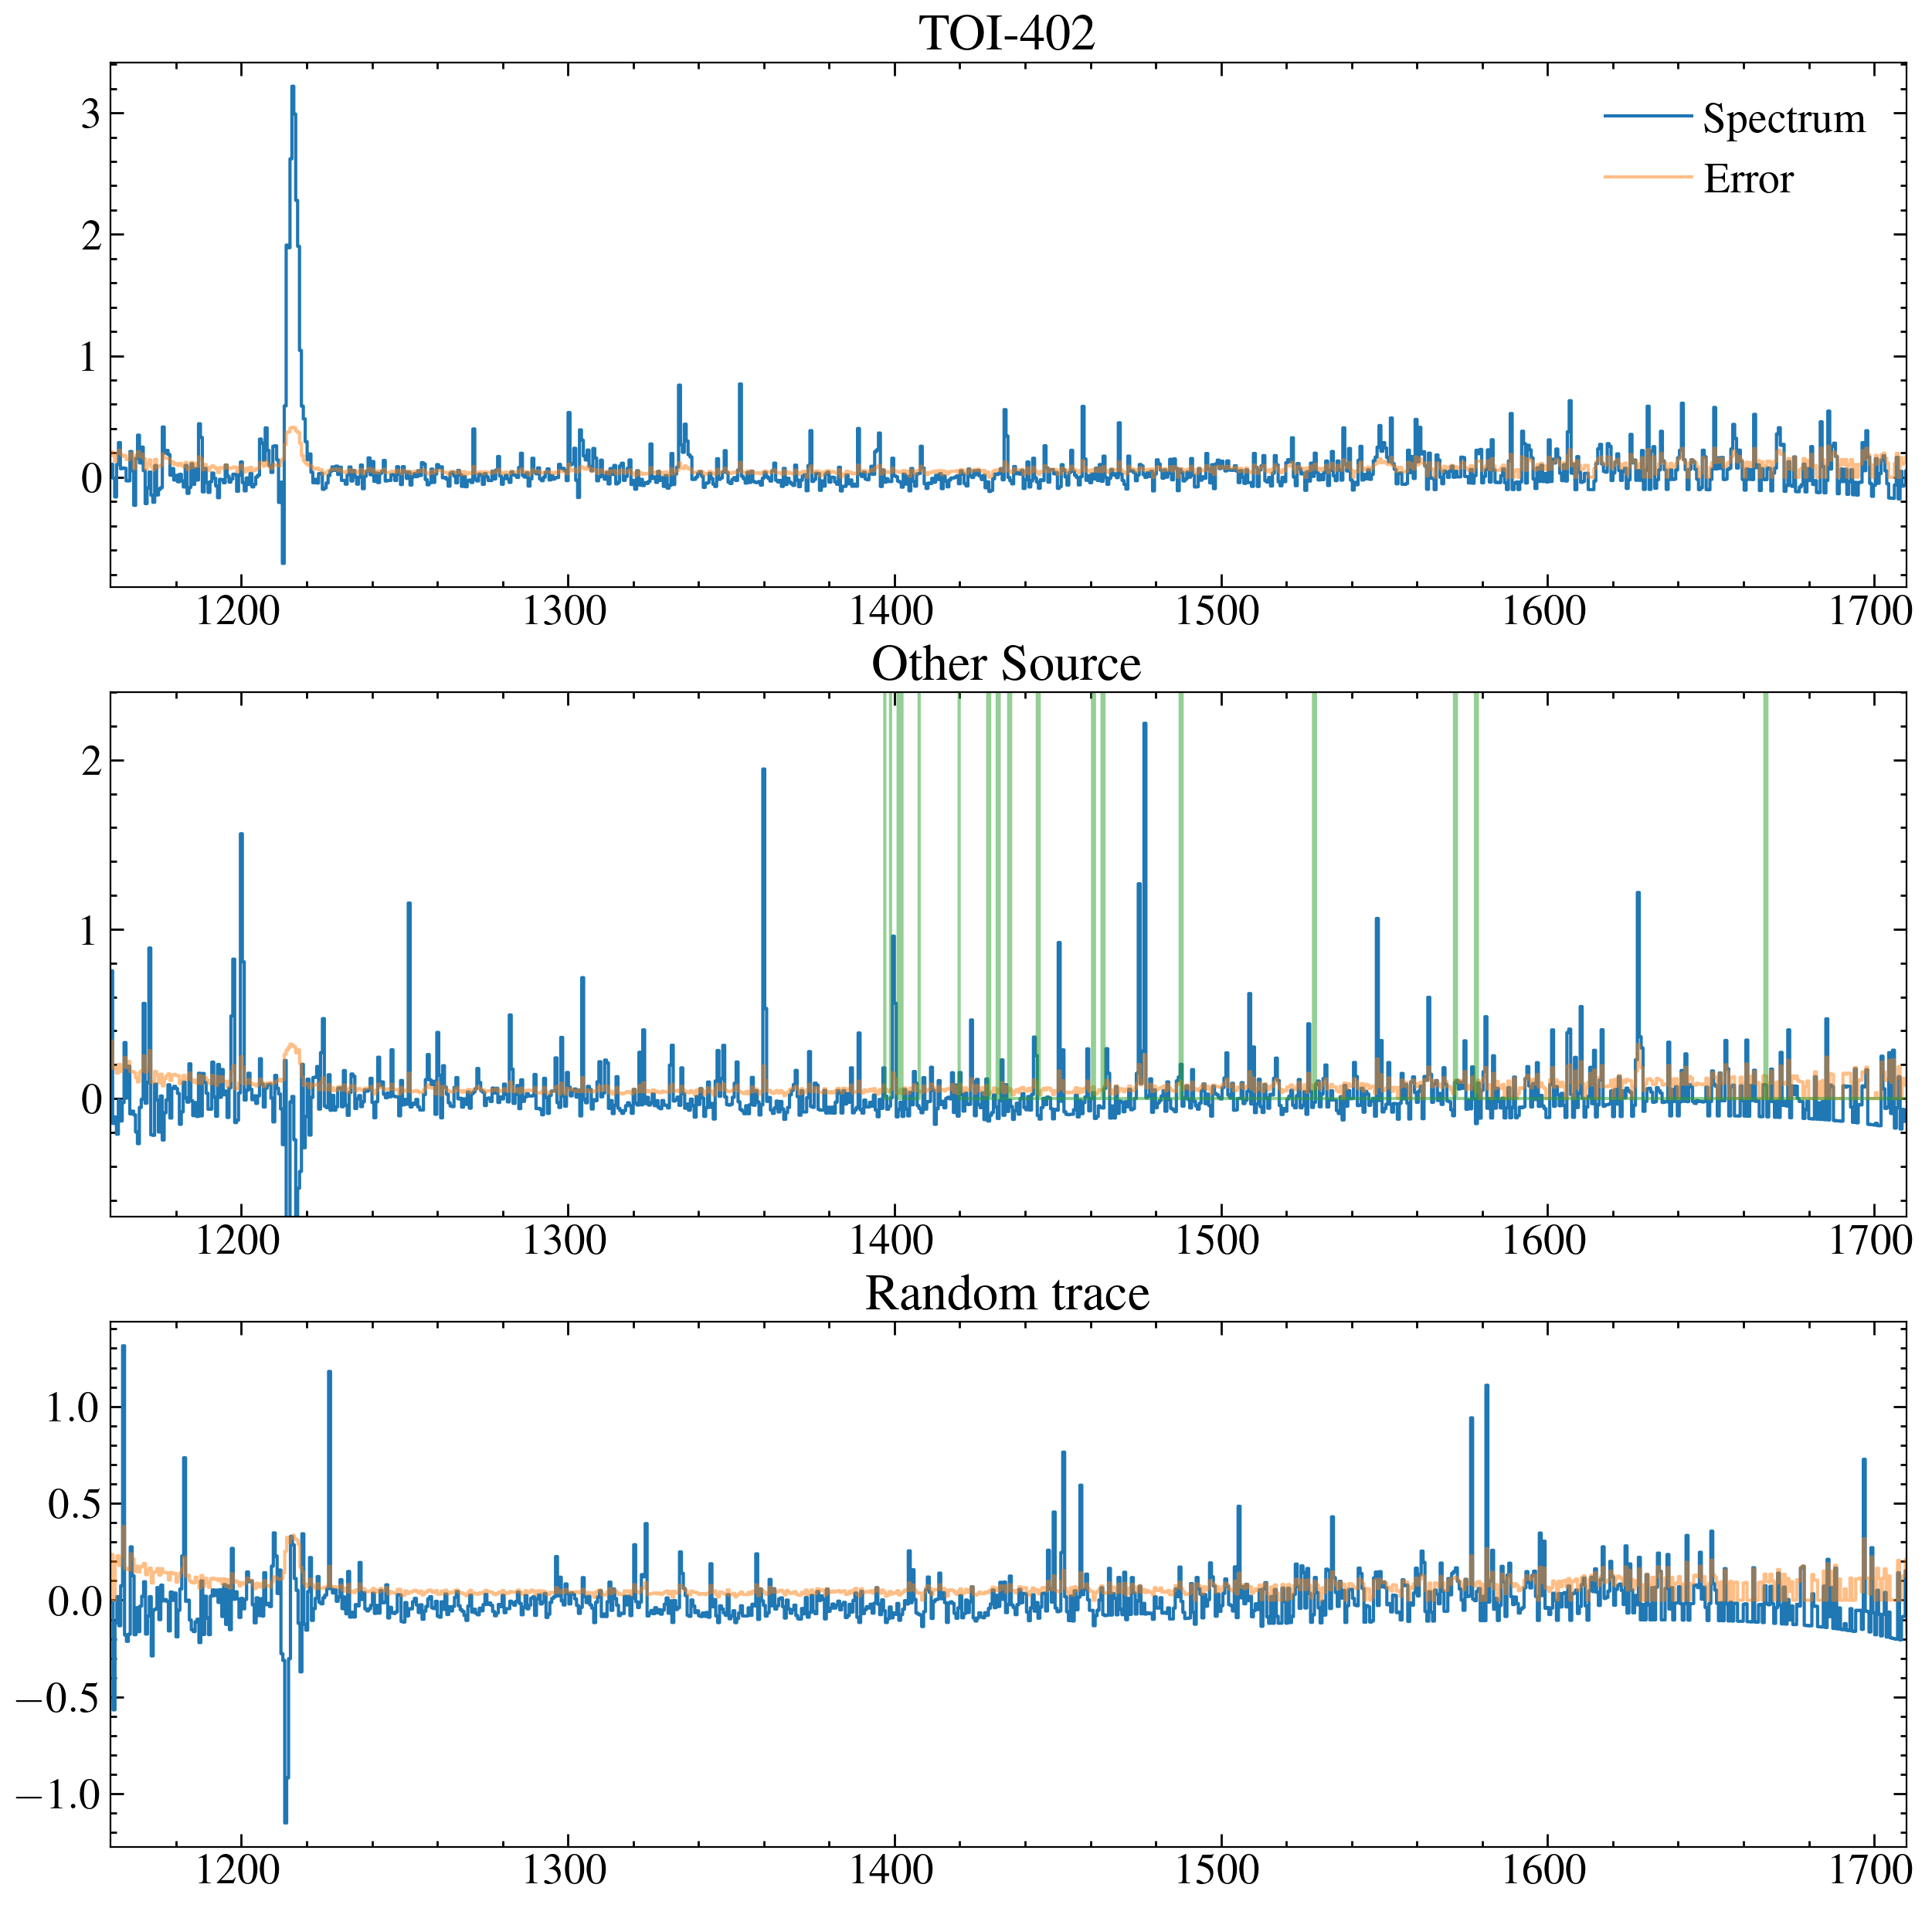

In [70]:
# fig, ax = plt.subplots(nrows=3, figsize=(15, 15))
# scale = 1e15
# data = fits.getdata('reextractions/toi-402/oeoo19010_new_x1d.fits', 1)[0]
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
# mask = w > 1160
# w, f, e = w[mask], f[mask], e[mask]
# ax[0].step(w, f*scale, where='mid', c='C0', label='Spectrum')
# ax[0].step(w, e*scale, where='mid', c='C1', alpha=0.5, label='Error')
# ax[0].set_title('TOI-402')
# ax[0].legend()
# ax[0].set_xlim(1160, 1710)

# data = fits.getdata('reextractions/toi-402/other_source_oeoo19010_new_x1d.fits', 1)[0]
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
# mask = w > 1160
# w, f, e = w[mask], f[mask], e[mask]
# ax[1].step(w, f*scale, where='mid', c='C0', label='Spectrum')
# ax[1].step(w, e*scale, where='mid', c='C1', alpha=0.5, label='Error')
# ax[1].step(w, data['DQ'][mask], where='mid', c='C2', alpha=0.5, label='Error')
# ax[1].set_title('Other Source')
# ax[1].set_xlim(1160, 1710)
# ax[1].set_ylim(-0.7, 2.4)

# data = fits.getdata('reextractions/toi-402/random_oeoo19010_new_x1d.fits', 1)[0]
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
# mask = w > 1160
# w, f, e = w[mask], f[mask], e[mask]
# ax[2].step(w, f*scale, where='mid', c='C0', label='Spectrum')
# ax[2].step(w, e*scale, where='mid', c='C1', alpha=0.5, label='Error')
# ax[2].set_title('Random trace')
# ax[2].set_xlim(1160, 1710)
# # ax[1].set_ylim(-0.7, 2.4)

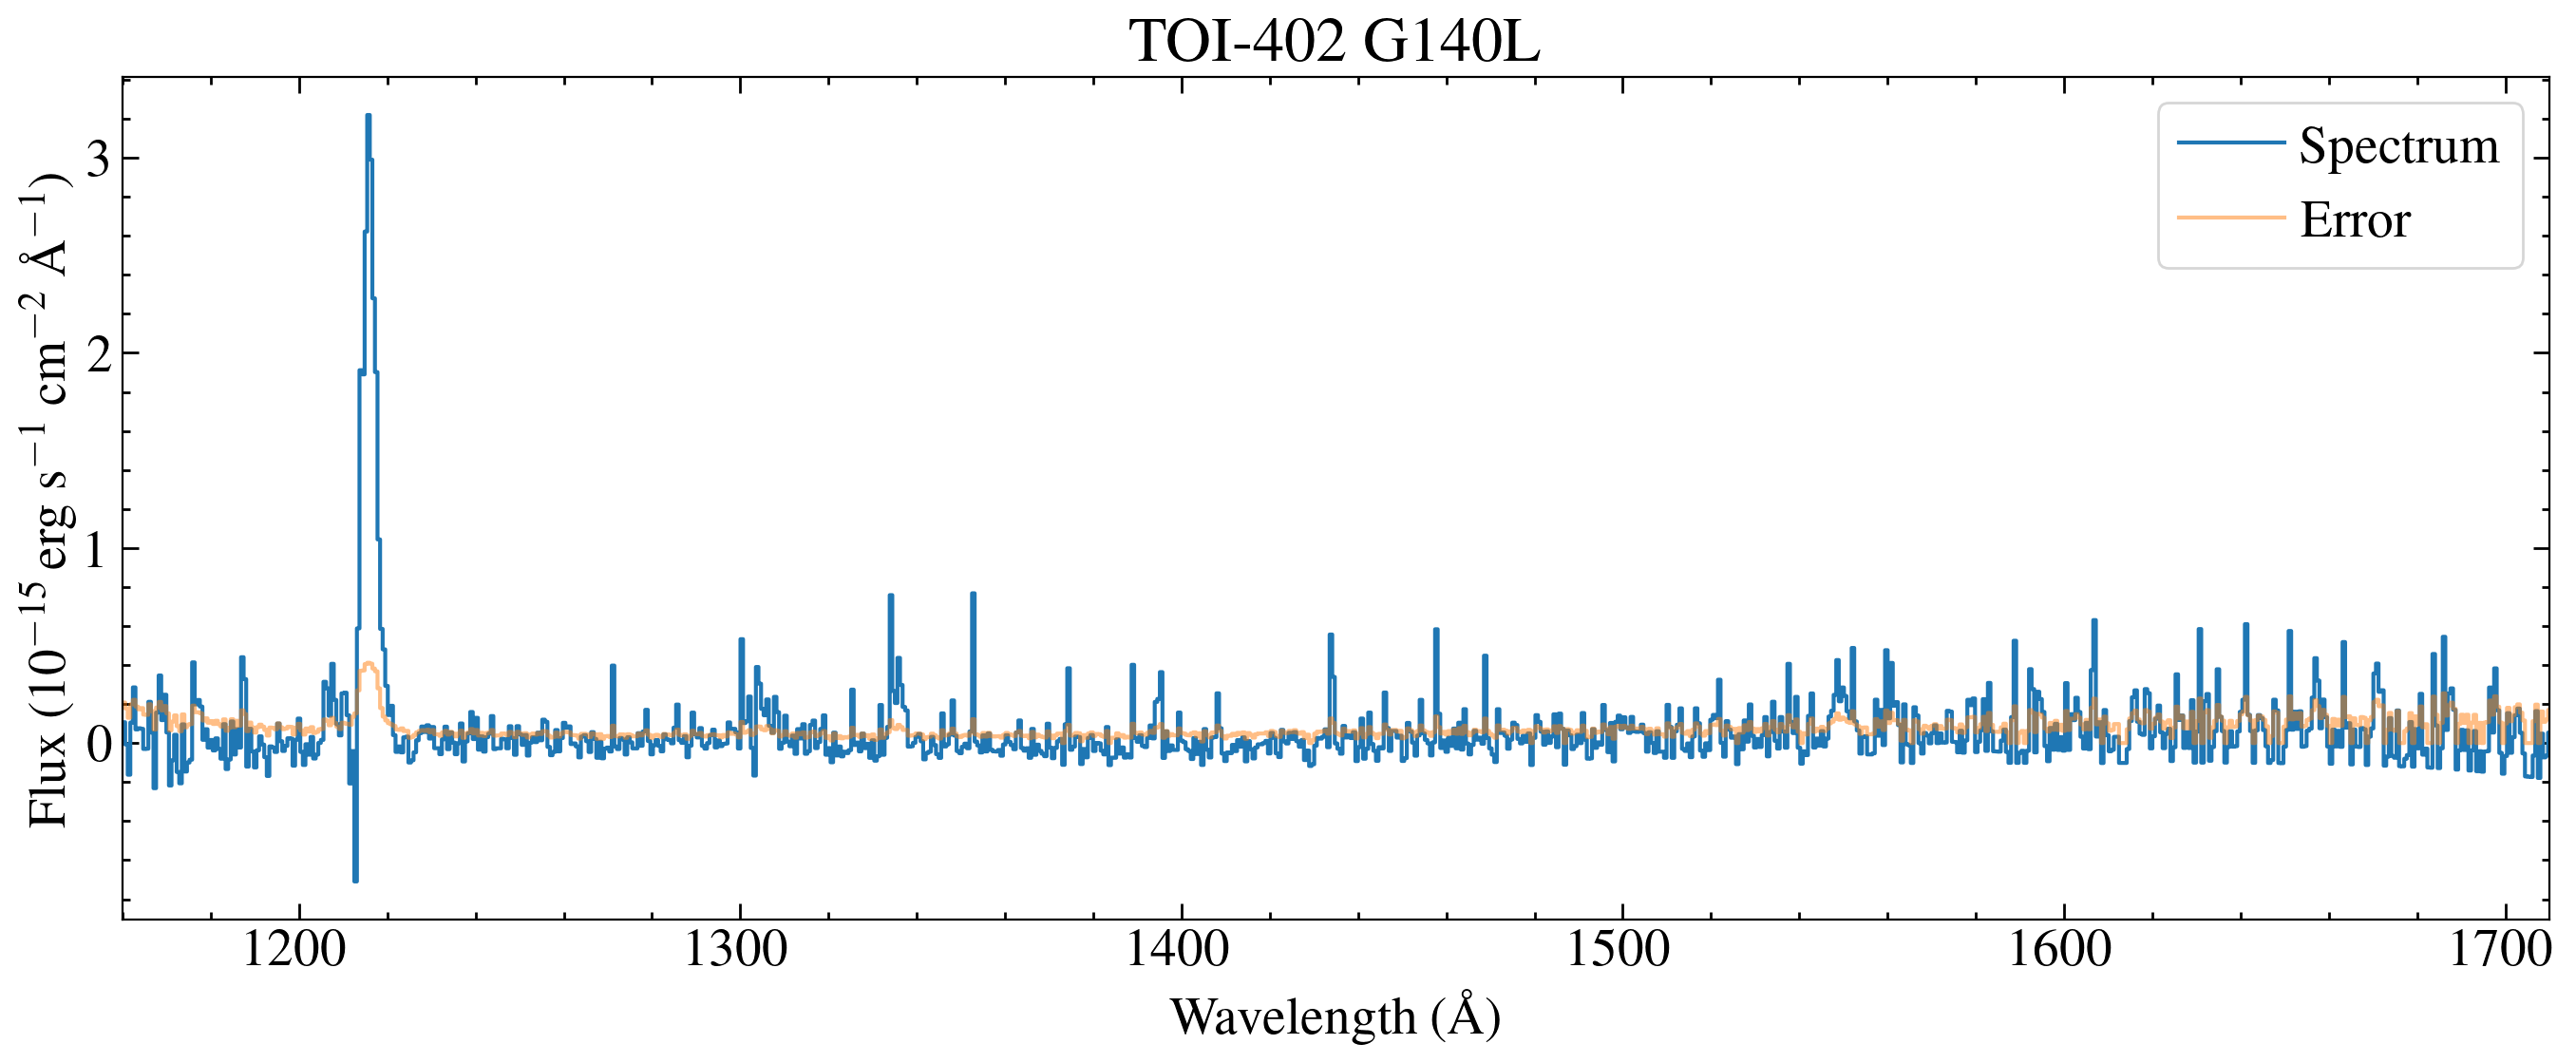

In [11]:
fig, ax = plt.subplots(figsize=(14, 6))
scale = 1e15
data = fits.getdata('reextractions/toi-402/oeoo19010_new_x1d.fits', 1)[0]
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = w > 1160
w, f, e = w[mask], f[mask], e[mask]
ax.step(w, f*scale, where='mid', c='C0', label='Spectrum')
ax.step(w, e*scale, where='mid', c='C1', alpha=0.5, label='Error')
ax.set_title('TOI-402 G140L')
ax.legend(frameon=True)
ax.set_xlim(1160, 1710)
ax.set_xlabel('Wavelength (\AA)')
ax.set_ylabel('Flux (10$^{-15}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

fig.tight_layout()
fig.savefig('plots/toi-402_g140l.png', facecolor='w')
fig.savefig('plots/toi-402_g140l.pdf')

reextractions/toi-402/oeoo19010_new_x1d.fits
G140L
[377.28726]
/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19020_x1d.fits
G230L
[513.3161]
/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19030_sx1.fits
G430L
[894.47546]


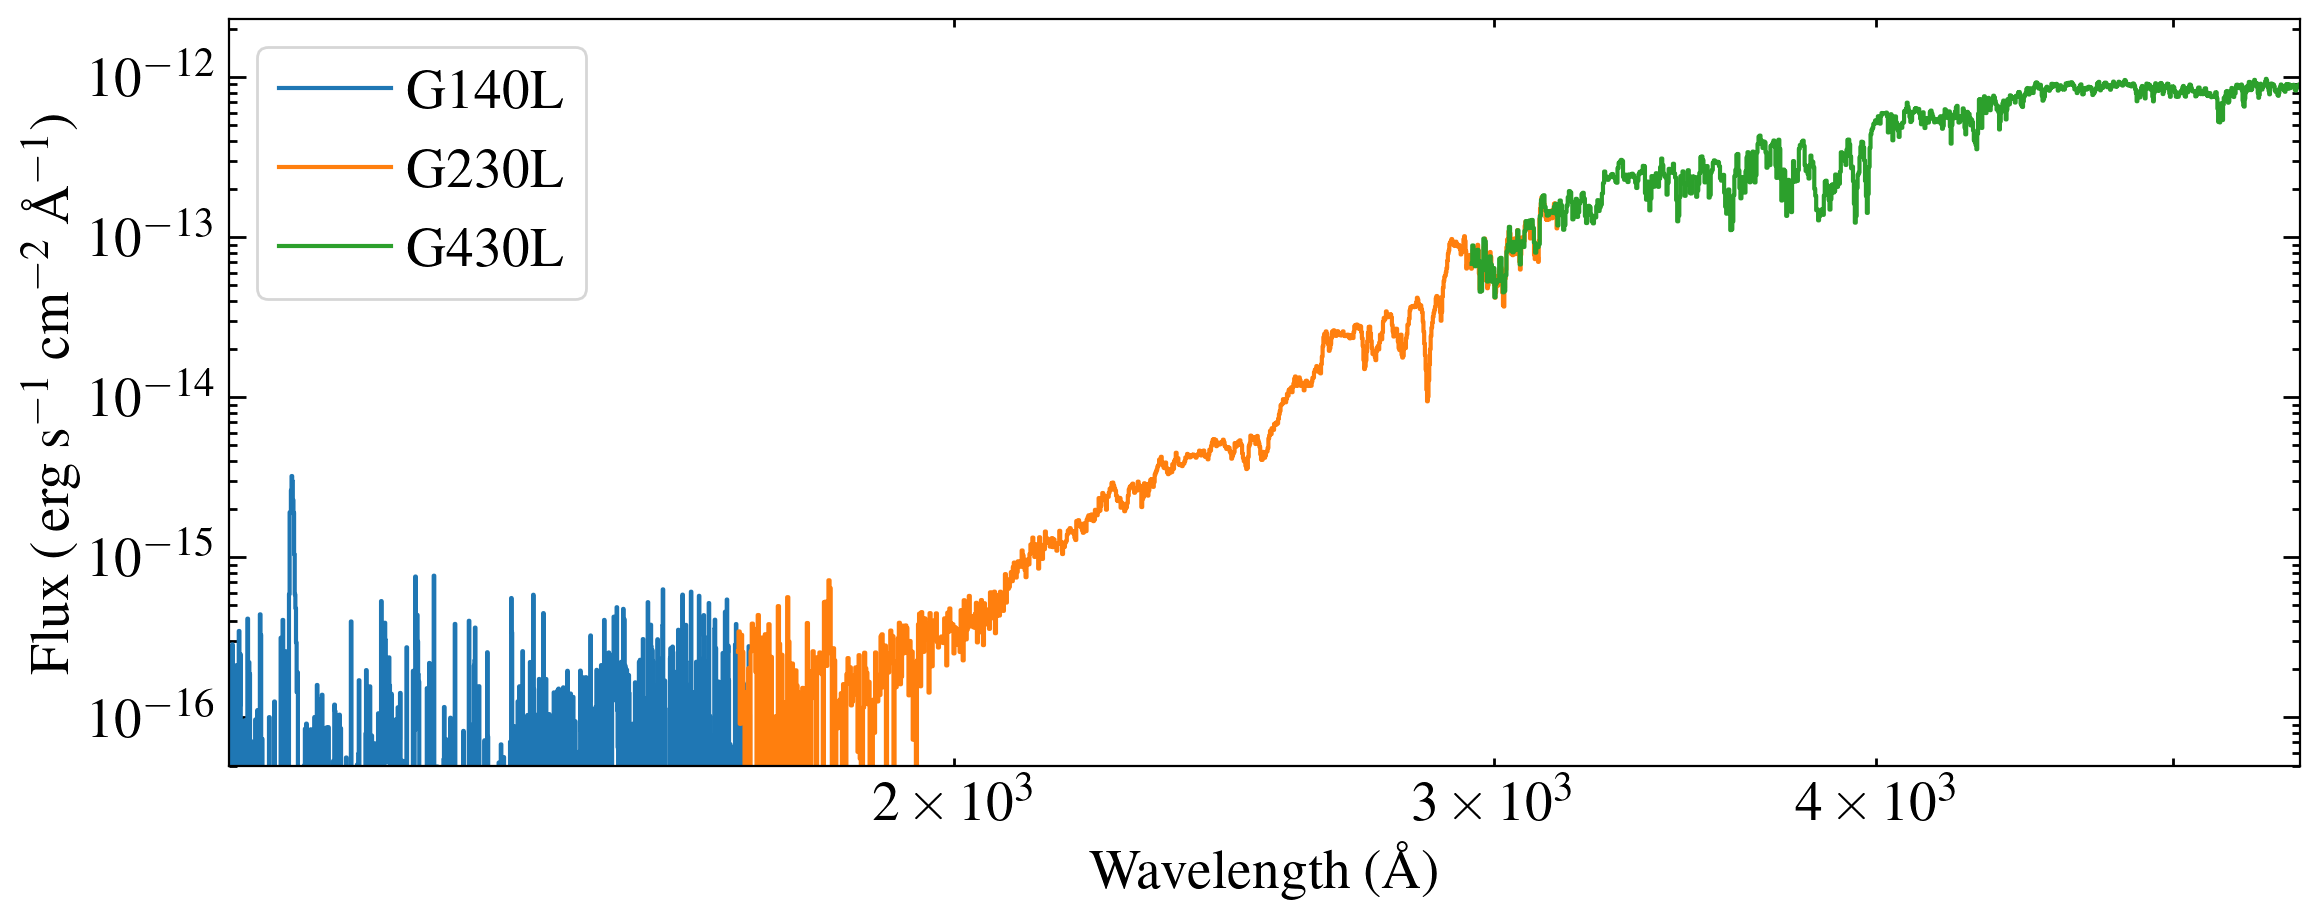

In [13]:
good_x1ds = ['reextractions/toi-402/oeoo19010_new_x1d.fits', x1ds[0], x1ds[2]]

fig, ax = plt.subplots(figsize=(12, 5))


for x in good_x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140L', 'Gl40M']:
        mask = w > 1160
    if grating == 'G230L':
        mask = (w > 1700) & (w <3150)
    if grating == 'G430L':
        mask = (w > 2950) & (w < 5650)
    w, f, e = w[mask], f[mask], e[mask]
    ax.step(w, f, where='mid', label = grating)#, c='C0')
    # plt.step(w, e, where='mid', c='C1')
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(5e-17)
ax.set_xlim(1160, 5500)
ax.legend(frameon=True)
ax.set_xlabel('Wavelength (\AA)')
ax.set_ylabel('Flux (\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
fig.tight_layout()
fig.savefig('plots/toi-402_hst.png', facecolor='w')
fig.savefig('plots/toi-402_hst.pdf')

In [15]:
import prepare_stis
print(good_x1ds)

['reextractions/toi-402/oeoo19010_new_x1d.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19020_x1d.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/oeoo19030_sx1.fits']


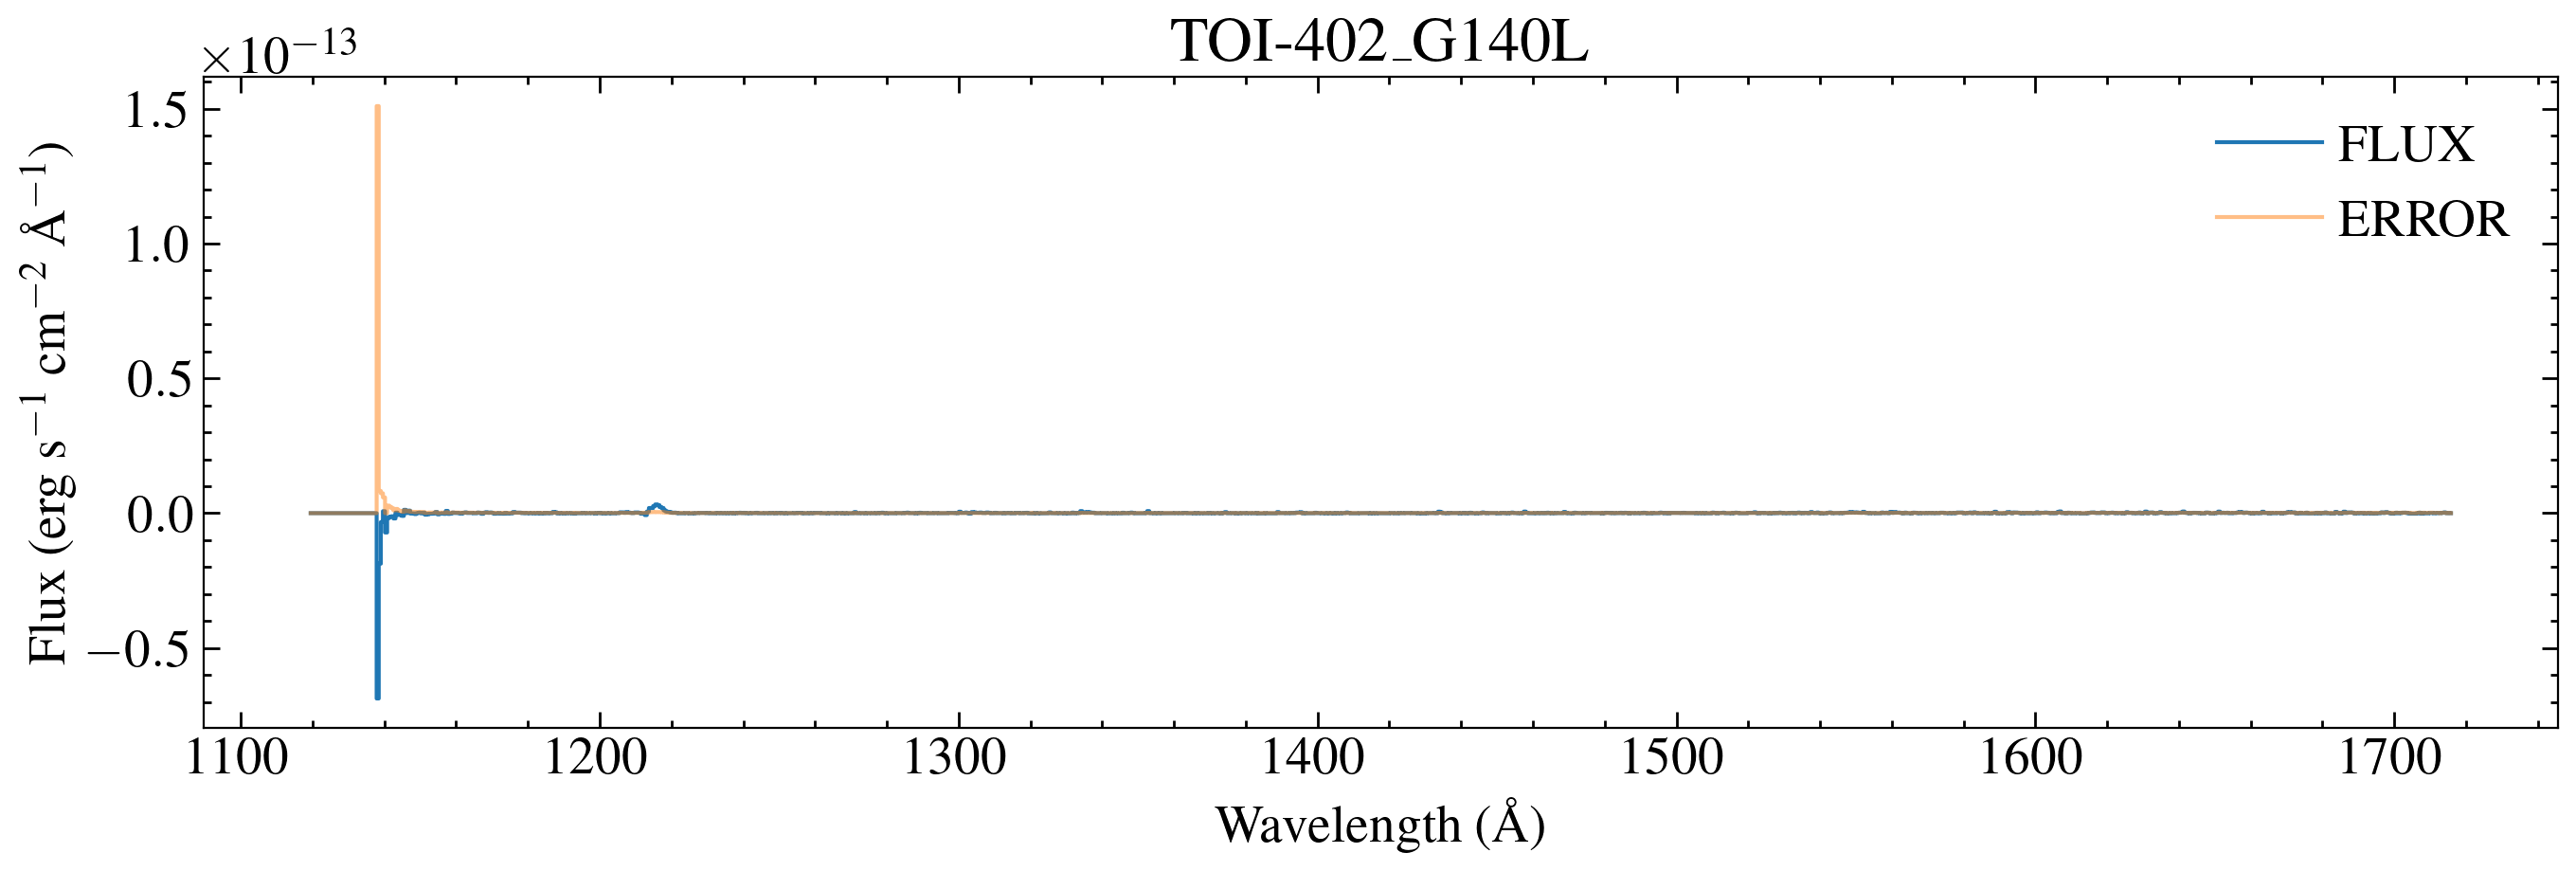

Spectrum saved as hlsp_muscles_hst_stis_toi-402_g140l_v1_component-spec.fits


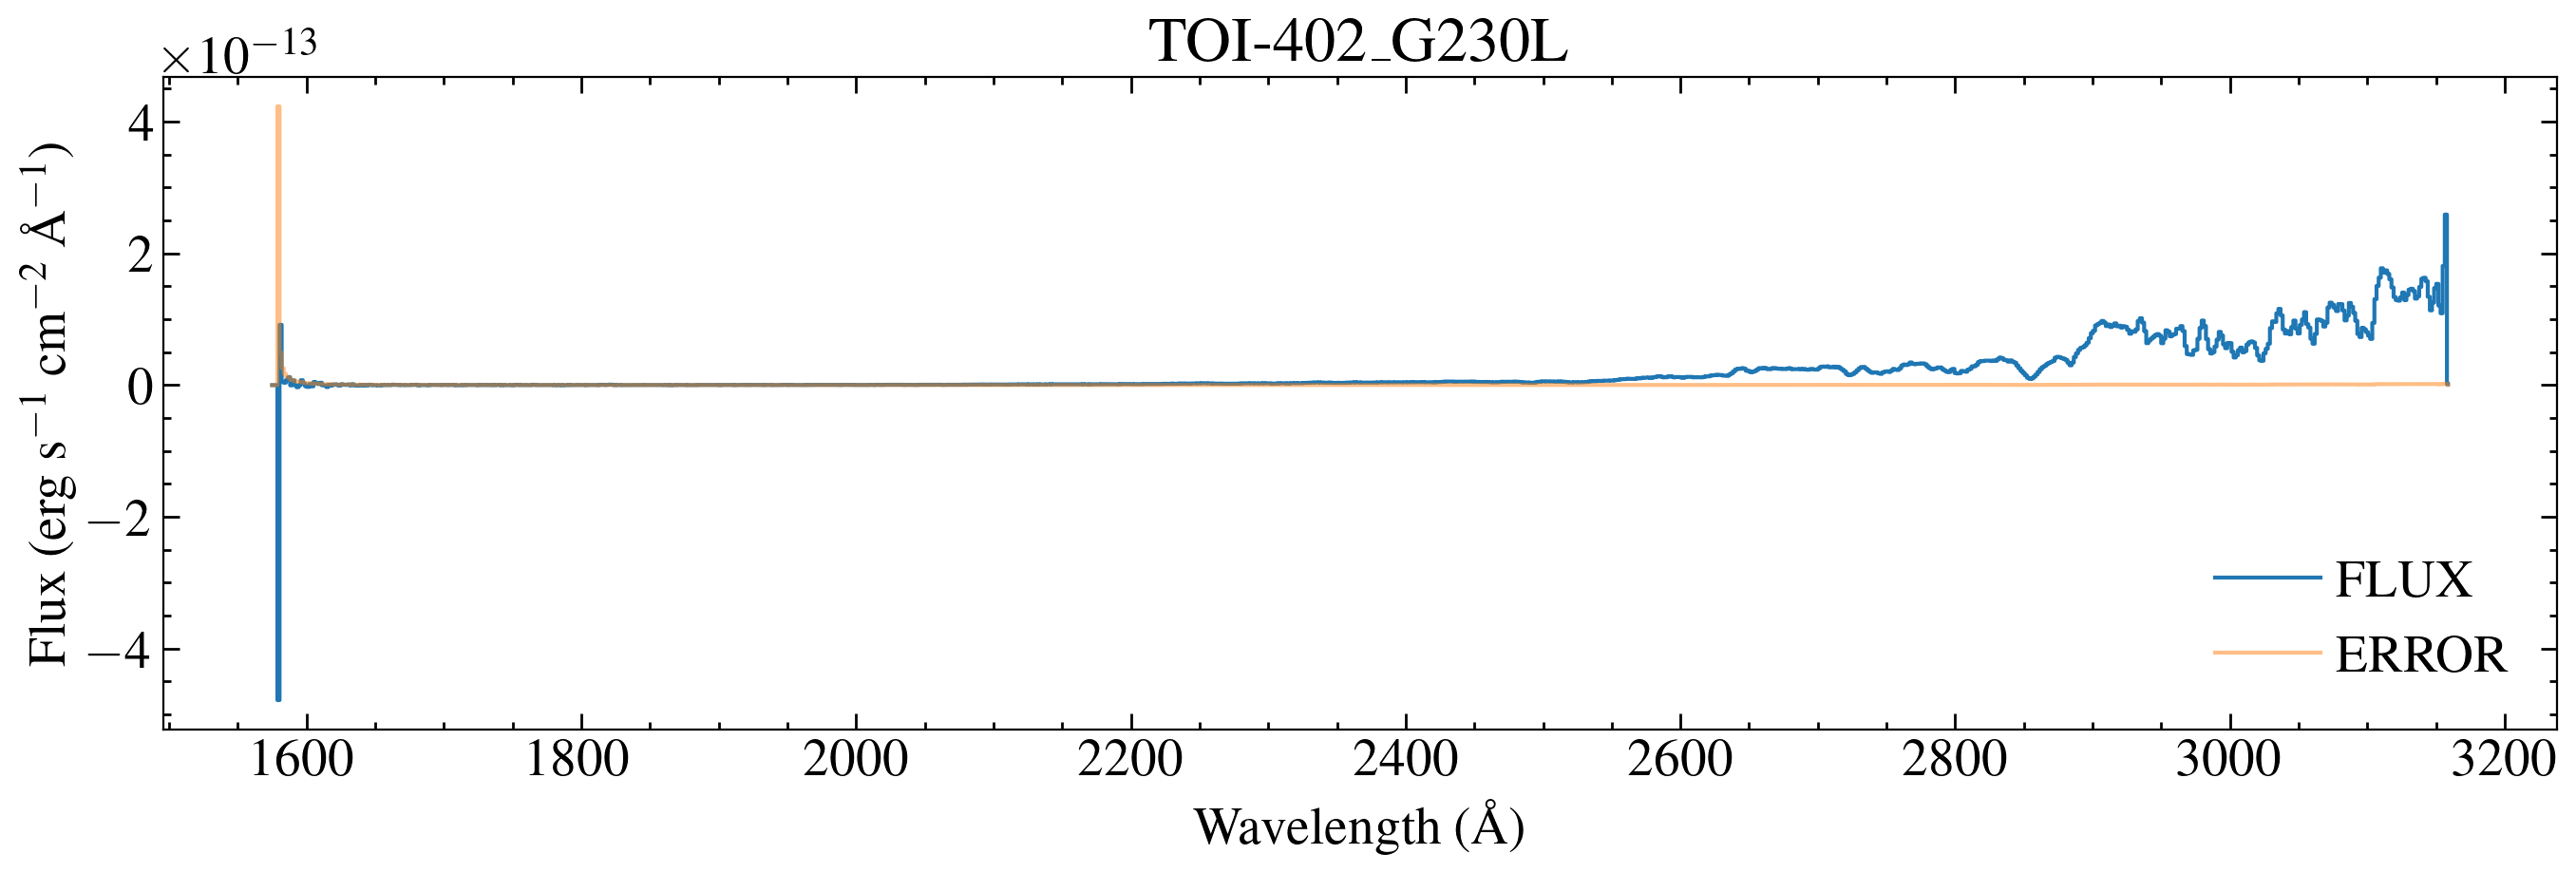

Spectrum saved as hlsp_muscles_hst_stis_toi-402_g230l_v1_component-spec.fits


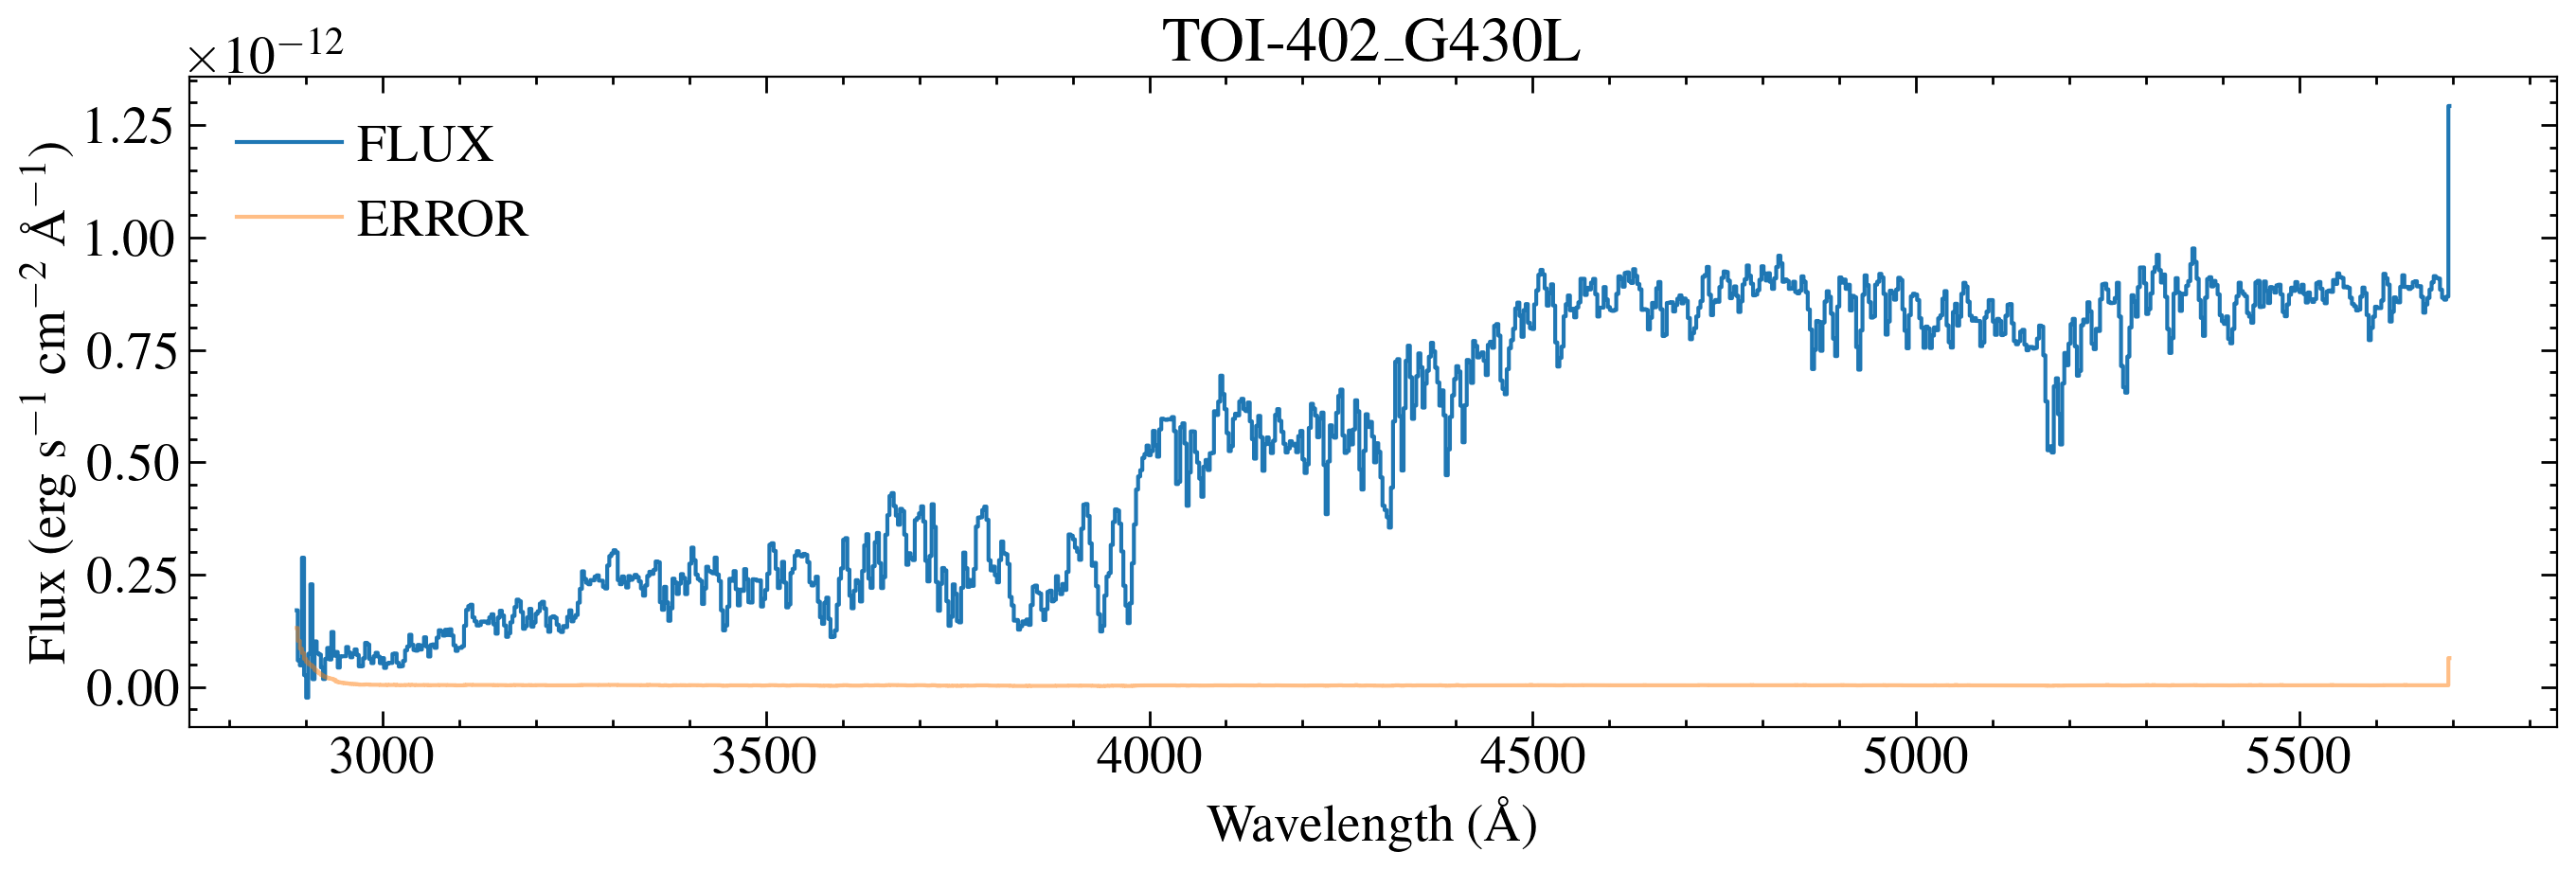

Spectrum saved as hlsp_muscles_hst_stis_toi-402_g430l_v1_component-spec.fits


In [16]:
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-402/used_spectra/'
savepath = 'draft_hlsp/toi-402/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'TOI-402')